# GradCAM example for 3 models

In [16]:
from pathlib import Path

current_dir = Path.cwd()  # this points to 'notebooks/' folder
proj_path = current_dir.parent.parent 
print(proj_path)

C:\Users\wenceslas\Documents\cours\ENSAE\2A\Normal\statapp\nlp_understanding


In [17]:
import pandas as pd
import numpy as np
import itertools
import torch
from torch.utils.data import DataLoader
import pickle
import re
from nltk.metrics import distance

from deep_nlp.cnncharclassifier import CNNCharClassifier, charToTensor
from src.deep_nlp.embed_cnn.embcnnmodel_gradcam import classifier3F
from deep_nlp.bilstm_cnn.bilstmcnn_gradcam import BilstmCnn
from deep_nlp.grad_cam.utils.letter import rebuild_text, prepare_heatmap, LetterToToken
from deep_nlp.grad_cam.plot import plot_bar_heatmap, plot_text_and_heatmap

## CNN Character level

In [18]:
# params
cnn_sequence_len= 1014
cnn_feature_num= 87
cnn_feature_size= 256
cnn_kernel_one= 7
cnn_kernel_two= 3
cnn_stride_one= 1
cnn_stride_two= 3
cnn_output_linear= 1024
cnn_num_class= 2
cnn_dropout= 0.5
cnn_cuda_allow= True

In [19]:
# Load model
model_path_saved= "data/06_models/cnn_char_classifier/cnn_char_model/cnn_char_model.pt"

with open(str(proj_path)+ "\\" + model_path_saved, 'rb') as f:
    model_saved= pickle.load(f)

In [20]:
# Load test data
data_df= pd.read_csv(str(proj_path)+ "\\" + "data/01_raw/allocine_test.csv")

test_data= charToTensor(data_df= data_df, sentence_max_size= cnn_sequence_len)

In [21]:
# Initialisation
parameters = {"sequence_len": cnn_sequence_len, "feature_num": cnn_feature_num
    , "feature_size": cnn_feature_size, "kernel_one": cnn_kernel_one
    , "kernel_two": cnn_kernel_two, "stride_one": cnn_stride_one
    , "stride_two": cnn_stride_two, "output_linear": cnn_output_linear
    , "num_class": cnn_num_class, "dropout": cnn_dropout}

In [22]:
model = CNNCharClassifier(**parameters)

if cnn_cuda_allow:
    model = torch.nn.DataParallel(model).cuda()
else:
    model = torch.nn.DataParallel(model)

model.load_state_dict(model_saved)

state_dict= model.module.state_dict() # delete module to allow cpu loading

cpu_model= CNNCharClassifier(**parameters).cpu()
cpu_model.load_state_dict(state_dict)

cpu_model.eval()

CNNCharClassifier(
  (before_conv): Sequential(
    (conv1_conv): Conv1d(87, 256, kernel_size=(7,), stride=(1,))
    (conv1_relu): ReLU()
  )
  (pool): Sequential(
    (conv1_maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (after_conv): Sequential(
    (conv2): Sequential(
      (0): Conv1d(256, 256, kernel_size=(7,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (conv4): Sequential(
      (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (conv5): Sequential(
      (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (conv6): Sequential(
      (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  

In [23]:
# Display results
def cnn_char_gradcam(index, threshold= None,**kwargs):
    """
    Display gradcam text with knowing the index text position
    
    -------
    
    kwargs:
        - model
        - loader : type charToTensor
        - cnn_sequence_len
        - params_graphics
    """
    loader= kwargs["loader"]
    model= kwargs["model"]
    type_map= kwargs["type_map"]
    num_class= kwargs["num_class"] 
    figsize= kwargs["figsize"]
    
    text_sentence, _= loader[index]
    text_sentence= torch.unsqueeze(text_sentence, 0)
    
    model.eval()
    output= model(text_sentence)
    print("Proba class 1 : {}".format(torch.exp(output)[:, 1].data.numpy()[0]))
    
    heatmap_= model.get_heatmap(text= text_sentence
                                    , num_class= num_class
                                    , dim= [0, 2]
                                    , type_map= type_map)
    
    # get the unique element
    heatmap_values= heatmap_[-1]
    
    # CNNChar rebuilt from input the text
    alphabet= loader.get_alphabet()+" "
    rebuild_sentence= rebuild_text(text= text_sentence
                                     , alphabet= alphabet
                                     , space_index= len(alphabet) - 1 #83 # ajout de +4 si pas fait
                                     , sequence_len= cnn_sequence_len)
    
    # Resize heatmap Brutal method
    heatmap_match_sentence_size_invert= prepare_heatmap(heatmap= heatmap_values
                                                    , text= rebuild_sentence)
    
    ## Transform character level to token one
    letter_to_token= LetterToToken(text= rebuild_sentence
                                   , heatmap= heatmap_match_sentence_size_invert)

    results_dict= letter_to_token.transform_letter_to_token(type= "tanh")
    tokens= results_dict["tokens"]
    heatmap_test= results_dict["heatmap"]
    
    if threshold: # if inquired
        condition= np.where(np.abs(heatmap_test) < threshold)[0] # if under, get index
        heatmap_test[condition]= 0 # replace undervalues by 0
    
    plot_text_and_heatmap(text= tokens
                      , heatmap= heatmap_test
                      , figsize= figsize
                      , fontsize_text= "small"
                      , cmap= "Greens" if type_map == "max" else "PiYG"
                      , word_or_letter= "word")
    pass

Proba class 1 : 0.9326661229133606


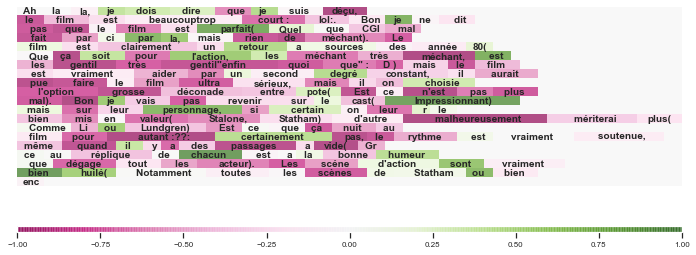

Proba class 1 : 0.9326661229133606


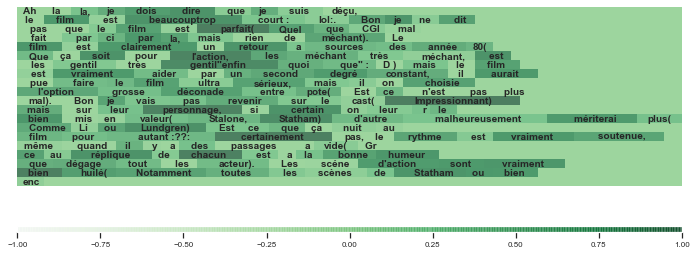

In [24]:
# %matplotlib
index= 14359 - 1
num_class= 1
figsize= (10, 4)
cnn_char_gradcam(index, model= cpu_model, loader= test_data, type_map= "normalized"
                 , num_class= num_class, figsize= figsize)
cnn_char_gradcam(index, model= cpu_model, loader= test_data, type_map= "max"
                 , num_class= num_class, figsize= figsize)

## Embedding vanilla

In [25]:
test_iterator_cnn_embed_path= "data/02_intermediate/test_iterator_cnn_embed.pkl"

with open(str(proj_path)+ "\\" + test_iterator_cnn_embed_path, 'rb') as f:
    test_iterator_cnn_embed= pickle.load(f)
    
print(type(test_iterator_cnn_embed))

<class 'torch.utils.data.dataloader.DataLoader'>


In [26]:
# Embedding model
embed_for_torch_path= "data/04_feature/w2v_torch.pkl"

with open(str(proj_path)+ "\\" + embed_for_torch_path, 'rb') as f:
    embed_for_torch= pickle.load(f)
    
print(type(embed_for_torch))

<class 'torch.Tensor'>


In [27]:
word_ind_dict_path= "data/04_feature/voc.pkl"

with open(str(proj_path)+ "\\" + word_ind_dict_path, 'rb') as f:
    word_ind_dict= pickle.load(f)
    
print(type(word_ind_dict))

<class 'dict'>


In [28]:
# Params
params_models = {"wv": embed_for_torch,"no_words": 67,"embedding_dim":200, "nb_filter":200
                 , "height_filter":tuple([1, 2, 3, 4, 5]), "output_dim":2, "dropout":0.8, "padded":True}

In [29]:
# Model dict
embed_cnn_model_for_save_path= "data/06_models/embed_cnn/embed_cnn_classifier/embed_cnn.pt"

with open(str(proj_path)+ "\\" + embed_cnn_model_for_save_path, 'rb') as f:
    embed_cnn_model_for_save= pickle.load(f)
    
print(type(embed_cnn_model_for_save))

<class 'collections.OrderedDict'>


In [30]:
model_embed = classifier3F(**params_models)

model_embed.load_state_dict(embed_cnn_model_for_save)
model_embed= model_embed.cpu()
model_embed.eval()

classifier3F(
  (before_conv): Sequential(
    (conv1_conv_1): Conv2d(1, 200, kernel_size=(1, 200), stride=(1, 1))
    (conv1_conv_2): Conv2d(1, 200, kernel_size=(2, 200), stride=(1, 1))
    (conv1_conv_3): Conv2d(1, 200, kernel_size=(3, 200), stride=(1, 1))
    (conv1_conv_4): Conv2d(1, 200, kernel_size=(4, 200), stride=(1, 1))
    (conv1_conv_5): Conv2d(1, 200, kernel_size=(5, 200), stride=(1, 1))
    (conv1_relu): ReLU()
  )
  (pool): Sequential(
    (conv1_maxpool): Sequential(
      (0): MaxPool1d(kernel_size=67, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (after_conv): Sequential(
    (dp): Dropout(p=0.8, inplace=False)
    (fc): Linear(in_features=1000, out_features=2, bias=True)
    (sm): Softmax(dim=1)
  )
  (embedding): Embedding(155564, 200)
  (conv1_conv): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(1, 200), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(2, 200), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(3, 200), stride=(1, 1))
    (3):

In [31]:
# [i.lemma_ for i in nlp("veux")][0]

In [37]:
!python -m spacy download fr_core_news_md
import spacy
nlp= spacy.load("fr_core_news_sm",  disable=["tagger", "parser","ner"])

  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.3.0-py3-none-any.whl size=46100673 sha256=17295e8e4f0115fea087c8d12761220b82fc1cfabac0f4041e4c2266411f4dab
  Stored in directory: C:\Users\wenceslas\AppData\Local\Temp\pip-ephem-wheel-cache-dbpic9p5\wheels\46\c8\4d\5ca33b0fe8e3e68134e74c94a44c0f6e80c7dc089540218b18
Successfully built fr-core-news-md
[+] Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [79]:
fast_lemm_token("Très")

'tres'

In [92]:
# display
import unicodedata

def split_sentence(token: str, pattern_token_split= r'[\s\.\,\:\;\(\)\[\]\&\!\?\/\\]+'):
    return re.split(pattern_token_split, token)

def clean_tokens(token: str, pattern= r'[\s\.\,\:\;\"\'\(\)\[\]\&\!\?\/\\]+'):
    cleaned_token= re.sub(pattern, "", token)
    return ''.join(c for c in unicodedata.normalize('NFD', cleaned_token)
                        if unicodedata.category(c) != 'Mn').lower()

def fast_lemm_token(token):
    if token != "":
        return [i.lemma_ for i in nlp(clean_tokens(token))][0]
    else:
        return ""
    
def compute_index_max_distance_jako(selected_word, tokenized_sentence, safe_threshold= 0.2
                                    , sentence_length_wihout_clean= 120):
    """
    jaro_winkler_sim = jaro_sim + ( l * p * (1 - jaro_sim) )
    jaro_sim = 0 if m = 0 else 1/3 * (m/|s_1| + m/s_2 + (m-t)/m)

    where:
        - |s_i| is the length of string s_i
        - m is the no. of matching characters
        - t is the half no. of possible transpositions.
    """
    stock_all_word_dist= []
    last_up= 0
    tokenized_sentence= tokenized_sentence[:sentence_length_wihout_clean] # sentence length, to ensure it is not looking for
    # not implemented words (more than 67 because 67 was after cleaning, stop word and lemme)
    for input_word in selected_word:
        stock_input_word_dist= []

        d= [distance.jaro_winkler_similarity(fast_lemm_token(input_word), fast_lemm_token(input_initial))
           for input_initial in tokenized_sentence]
        # safety threshold, if under stop the processus for the token
        if max(d) <= safe_threshold:
            continue
        else: 
            tokenized_sentence= tokenized_sentence[np.argmax(d):]
            last_up= np.argmax(d) + last_up # we cut the tokenized list, so we remember where was the
        # last highest value in index
        stock_all_word_dist.append(last_up)
    return np.array(stock_all_word_dist)


def embed_gradcam(index, heatmap_index, index_nothing= None, model_type= None
                  , threshold= None, figsize_second= (10, 4), fontsize_text_second= "small" 
                  , threshold_second= 10, **kwargs):
    """
    Display gradcam text with knowing the index text position
    
    -------
    
    kwargs:
        - model
        - loader : type charToTensor
        - cnn_sequence_len
        - params_graphics
    """
    data_loader= kwargs["data_loader"]
    model= kwargs["model"]
    type_map= kwargs["type_map"]
    num_class= kwargs["num_class"] 
    figsize= kwargs["figsize"]
    vocab= kwargs["vocab"]
    initial_review= kwargs["initial_review"]
    
    text_sentence, _= next(itertools.islice(data_loader, index, None))
    if model_type == "bilstm":
        text_sentence= text_sentence.to(torch.int64)
    
    model.eval()
    output= model(text_sentence)
    print("Proba class 1 : {}".format(output[:, 1].data.numpy()[0]))
    
    heatmap_= model.get_heatmap(text= text_sentence
                                    , num_class= num_class
                                    , dim= [0, 2]
                                    , type_map= type_map)
    heatmap_values= heatmap_[heatmap_index]
    
    text_index = text_sentence.squeeze().numpy()
    vocab_reverse= {y:x for x,y in vocab.items()}
    word = np.array([vocab_reverse.get(index, "") for index in text_index])
    
    if index_nothing is None: # generate warning but its ok dude
        index_nothing = np.array([])
    selected_word_bool = np.in1d(text_index, index_nothing)
    # Get index of word we want
    selected_word_index = np.where((~selected_word_bool)|(word != ""))[0]
    # Select interesting words
    selected_word = word[selected_word_index]
    selected_heatmap_values= heatmap_values[selected_word_index]
    
    if threshold: # if inquired
        condition= np.where(np.abs(selected_heatmap_values) < threshold)[0] # if under, get index
        selected_heatmap_values[condition]= 0 # replace undervalues by 0

    # Token heatmap
    plot_text_and_heatmap(text= selected_word.tolist()
                      , heatmap= selected_heatmap_values
                      , figsize= figsize
                      , fontsize_text= "small"
                      , cmap= "Greens" if type_map == "max" else "PiYG"
                      , word_or_letter= "word")
    
    # Good token heatmap
    tokenized_sentence= split_sentence(initial_review)
    
    # Compute token distance between initial sentence token
    stock_all_word_max_dist_id= compute_index_max_distance_jako(selected_word, tokenized_sentence)
#     simi_tokens= np.argmax(stock_all_word_dist, axis= 1) 
    based_heatmap= np.zeros(len(tokenized_sentence))

    based_heatmap[stock_all_word_max_dist_id]= selected_heatmap_values[:stock_all_word_max_dist_id.shape[0]]
    
    plot_text_and_heatmap(text= tokenized_sentence
                      , heatmap= based_heatmap
                      , figsize= figsize_second
                      , fontsize_text= fontsize_text_second
                      , cmap= "Greens" if type_map == "max" else "PiYG"
                      , threshold= threshold_second
                      , word_or_letter= "word")
    
    return selected_word, selected_heatmap_values

Proba class 1 : 9.950574894901365e-05


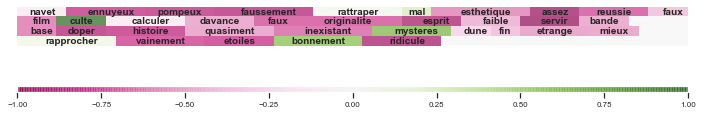

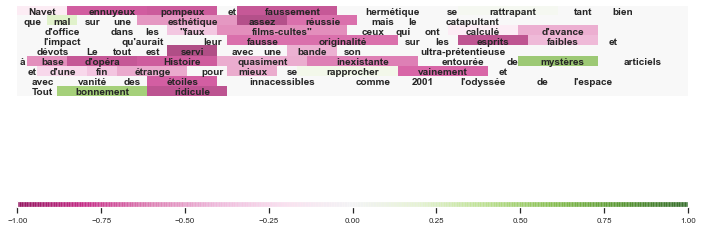

In [93]:
index= 16237 - 1
num_class= 1
figsize= (10, 4)
index_nothing= np.array([155563, 155562])

data_review_test= pd.read_csv("../GradCam/all_model_prediction.csv")
initial_review_tt= data_review_test["review"].values

initial_review= initial_review_tt[index]

selected_word, selected_heatmap_values= embed_gradcam(index, heatmap_index= -1, model= model_embed
                                                      , data_loader= test_iterator_cnn_embed
                                                      , type_map= "normalized", vocab= word_ind_dict
                                                      , num_class= num_class, figsize= figsize
                                                      , index_nothing= index_nothing
                                                      , initial_review= initial_review
                                                      , figsize_second= (10, 10))

## Bilstm

In [94]:
#
embed_matrix_path= "data/02_intermediate/bilstm_cnn/embed_matrix.pkl"

with open(str(proj_path)+ "\\" + embed_matrix_path, 'rb') as f:
    embed_matrix= pickle.load(f)
    
print(type(embed_matrix))

<class 'numpy.ndarray'>


In [95]:
word_ind_dict_path_bilstm= "data/04_feature/voc_bilstm.pkl"

with open(str(proj_path)+ "\\" + word_ind_dict_path_bilstm, 'rb') as f:
    word_ind_dict_bilstm= pickle.load(f)
    
print(type(word_ind_dict_bilstm))

<class 'dict'>


In [96]:
#
test_batch_bilstm_path= "data/02_intermediate/test_iterator_cnn_bilstm.pkl"

with open(str(proj_path)+ "\\" + test_batch_bilstm_path, 'rb') as f:
    test_batch_bilstm= pickle.load(f)
    
print(type(test_batch_bilstm))#BiLSTM + CNN
num_epochs=  50
batch_size= 32
patience= 5
lr= 0.001
input_dim= 200
hidden_dim= 128
layer_dim= 2
feature_size= 256
output_dim= 2
kernel_size= 3
dropout_rate= 0.5
sentence_size= 67
padded= True

<class 'torch.utils.data.dataloader.DataLoader'>


In [97]:
#
bilstm_cnn_model_for_save_path= "data/06_models/bilstm_cnn/bilstm_cnn_classifier/bilstm_cnn.pt"

with open(str(proj_path)+ "\\" + bilstm_cnn_model_for_save_path, 'rb') as f:
    bilstm_cnn_model_for_save= pickle.load(f)
    
print(type(bilstm_cnn_model_for_save))

<class 'collections.OrderedDict'>


In [98]:
model = BilstmCnn(embed_matrix, sentence_size, input_dim, hidden_dim
                  , layer_dim, output_dim, feature_size, kernel_size, dropout_rate, padded)

if cnn_cuda_allow:
    model = torch.nn.DataParallel(model).cuda()
else:
    model = torch.nn.DataParallel(model)

model.load_state_dict(bilstm_cnn_model_for_save)

state_dict= model.module.state_dict() 

cpu_bilstm_model= BilstmCnn(embed_matrix, sentence_size, input_dim, hidden_dim
                  , layer_dim, output_dim, feature_size, kernel_size, dropout_rate, padded).cpu()

cpu_bilstm_model.load_state_dict(state_dict)
cpu_bilstm_model

BilstmCnn(
  (before_conv): Sequential(
    (conv): Sequential(
      (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (pool): Sequential(
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (after_conv): Sequential(
    (fc): Linear(in_features=8448, out_features=2, bias=True)
    (sm): Softmax(dim=1)
  )
  (embedding): Embedding(144214, 200, padding_idx=0)
  (LSTM): LSTM(200, 128, num_layers=2, dropout=0.5, bidirectional=True)
  (convLayer): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=8448, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

Proba class 1 : 0.04010598734021187


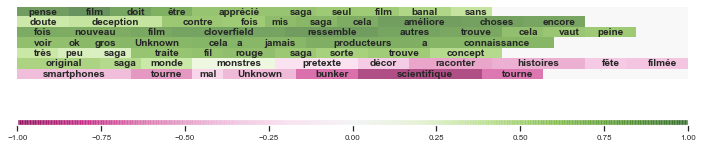

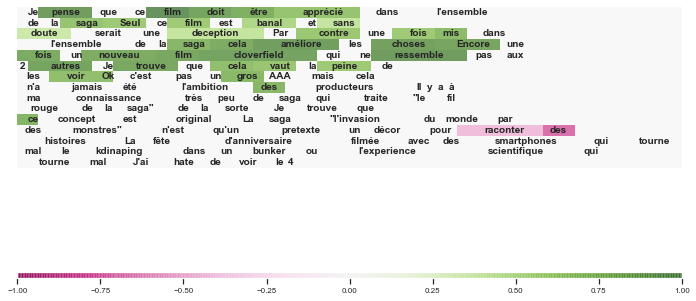

In [99]:
index= 8464 - 1
num_class= 1
figsize= (10, 4)
index_nothing= np.array([144213])

data_review_test= pd.read_csv("../GradCam/all_model_prediction.csv")
initial_review_tt= data_review_test["review"].values

initial_review= initial_review_tt[index]

selected_word, selected_heatmap_values= embed_gradcam(index, heatmap_index= -1, model_type= "bilstm"
                                                      , model= cpu_bilstm_model
                                                      , data_loader= test_batch_bilstm
                                                      , type_map= "normalized"
                                                      , vocab= word_ind_dict_bilstm
                                                      , num_class= num_class, figsize= figsize
                                                      , index_nothing= index_nothing
                                                      , initial_review= initial_review
                                                      , figsize_second= (10, 10))

## Print all local interpretability for GradCAM

In [100]:
index_to_print= np.array([14359, 16238, 7399, 18593, 17478, 1635, 8273, 17546, 5412, 8464, 12148, 4764
                 , 4629, 19019, 8670, 12221, 7087, 13267, 18238])
label_data= np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1])

index_to_print -= 1

index= 14359 - 1
num_class= 1
figsize= (10, 4)
index_nothing_bilstm= np.array([144213])
index_nothing_vanilla= np.array([155563, 155562])


data_review_test= pd.read_csv("../GradCam/all_model_prediction.csv")
initial_review_tt= data_review_test["review"].values

initial_review= initial_review_tt[index]

In [101]:
def print_all_model_interpretability(index, threshold= None):
    # CNN Character level
    print("CNN Character level")
    cnn_char_gradcam(index, threshold= threshold, model= cpu_model, loader= test_data
                     , type_map= "normalized", num_class= num_class, figsize= figsize)
    
    # Vanilla Embed
    print("Embed CNN")
    _, _= embed_gradcam(index, heatmap_index= -1, model= model_embed, threshold= threshold
                                                      , data_loader= test_iterator_cnn_embed
                                                      , type_map= "normalized", vocab= word_ind_dict
                                                      , num_class= num_class, figsize= figsize
                                                      , index_nothing= index_nothing
                                                      , initial_review= initial_review
                                                      , figsize_second= (10, 10))
    
    # BILSTM Embed
    print("BILSTM CNN")
    _, _= embed_gradcam(index, heatmap_index= -1, model_type= "bilstm", threshold= threshold
                                                      , model= cpu_bilstm_model
                                                      , data_loader= test_batch_bilstm
                                                      , type_map= "normalized"
                                                      , vocab= word_ind_dict_bilstm
                                                      , num_class= num_class, figsize= figsize
                                                      , index_nothing= index_nothing
                                                      , initial_review= initial_review
                                                      , figsize_second= (10, 10))
    pass



14358
True label : 1


Ah la la,je dois dire que je suis déçu,le film est beaucouptrop court :lol:.Bon je ne dit pas que le film est parfait(Quel que CGI mal fait par ci par la,mais rien de méchant).Le film est clairement un retour a sources des année 80(Que ça soit pour l'action,les méchant très méchant,est les gentil très gentil"enfin quoi que" :D )mais le film est vraiment aider par un second degré constant,il aurait pue faire le film ultra sérieux,mais il on choisie l'option grosse déconade entre pote(Est ce n'est pas plus mal).Bon je vais pas revenir sur le cast(Impressionnant)mais sur leur personnage,si certain on leur rôle bien mis en valeur(Stalone,Statham)d'autre malheureusement mériterai plus(Comme Li ou Lundgren)Est ce que ça nuit au film pour autant :??: certainement pas,le rythme est vraiment soutenue, même quand il y a des passages a vide(Grâce au réplique de chacun est a la bonne humeur que dégage tout les acteur).Les scéne d'action sont vraiment bien huilé(Notamment t

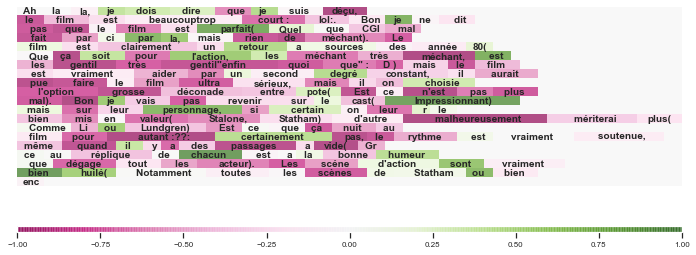

Embed CNN
Proba class 1 : 0.16792473196983337


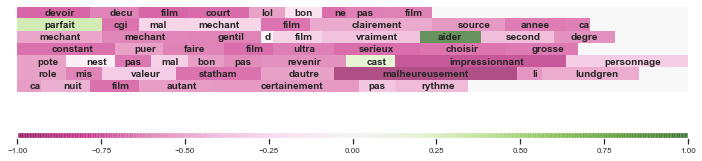

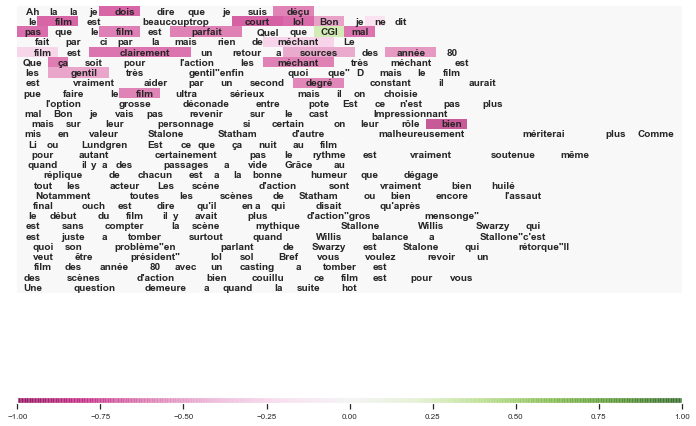

BILSTM CNN
Proba class 1 : 0.39950862526893616


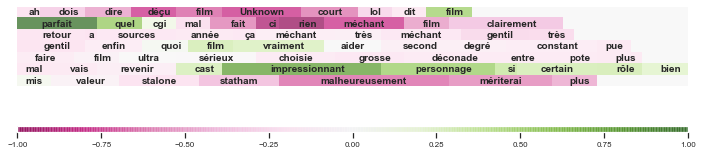

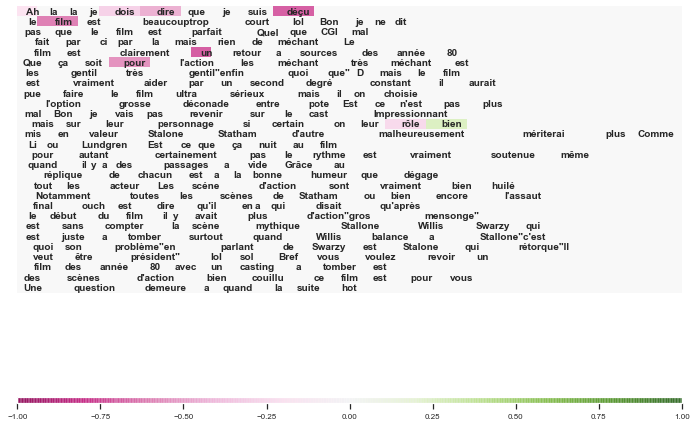



16237
True label : 1


Après le déjà superbe "Mademoiselle" Chambon" (2009) Stephane Brizé revient avec toujours autant de finesse. La promo autour du film s'est focalisé sur le suicide assisté, actualité et débat brûlants aidant, mais je n'ai pas pris ce film sous cet angle. En effet le thème me semble beaucoup plus être la difficulté de communiquer et les liens mère-fils ; ici entre une mère assez rugueuse, amère, plongée dans la solitude et qui se sait condamnée avec un fils qui sort de prison, entre ingratitude maladroite et la réinsertion mal assumée. Le réalisateur use d'une mise en scène tout en pudeur, découpé en plan-séquence qui ajoute au silence pesant tout les subtilités des sentiments. Un film aussi dur et austère que l'est le quotidien des non-dits entre le fils et la mère... Mais aussi et surtout un film d'une belle justesse, non dénué d'une petite note de poésie, bonne inspiration pour atténuer la tragédie qui se profile. Juste un petit bémol pour le personnage du fil

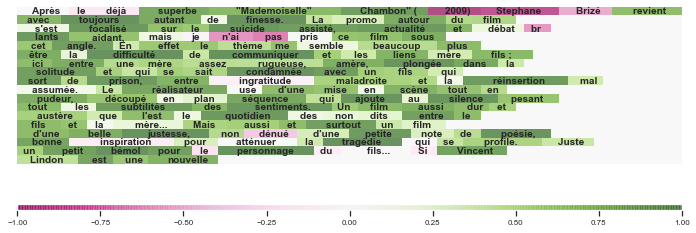

Embed CNN
Proba class 1 : 0.9557337760925293


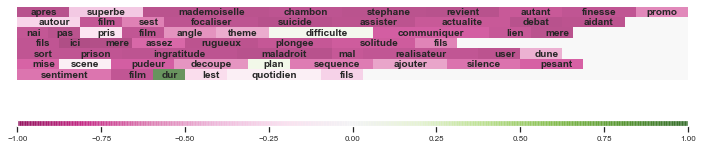

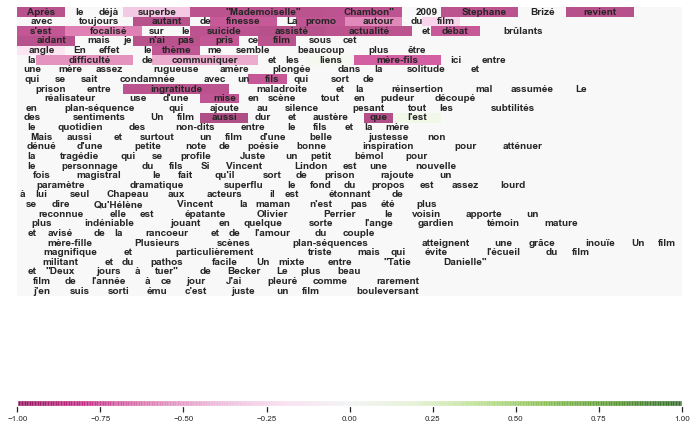

BILSTM CNN
Proba class 1 : 0.9731196761131287


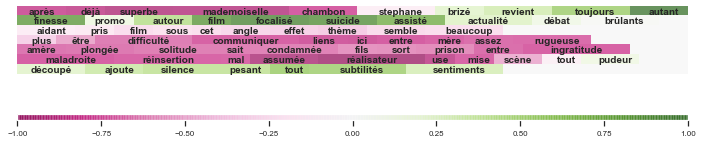

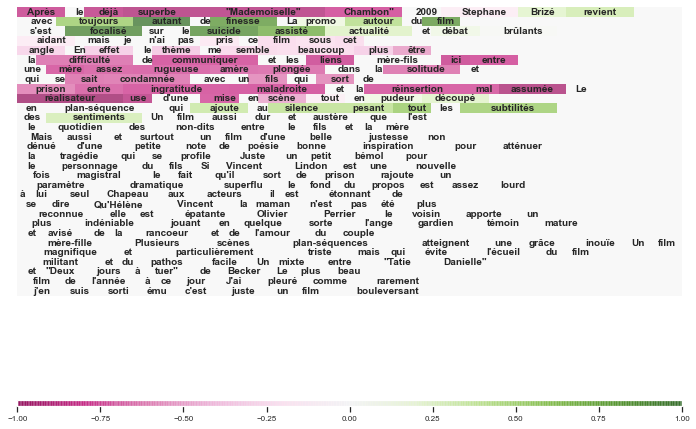



7398
True label : 1


C'est l'histoire simple et magnifique d'un taret qui veut tendre un fil entre les deux tours du World Trend Center. Une 3D impeccable. Deux tours Sublime. Une histoire qui nous évade loin dans le rêve. Bref si vous aimez les histoires ce film ne peut pas vous décevoir De belles musiques d'Alan Silvestri. Une aventure à ne pas manquer si vous vous senter prêt à affronté l'équilibre de Philippe Petit !!!


CNN Character level
Proba class 1 : 0.9959036707878113


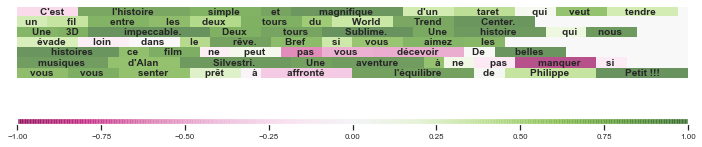

Embed CNN
Proba class 1 : 0.9934533834457397


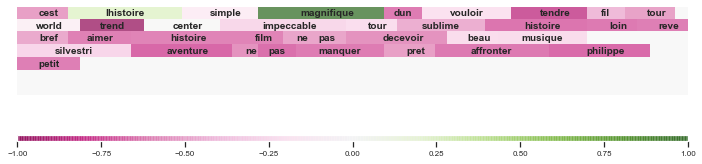

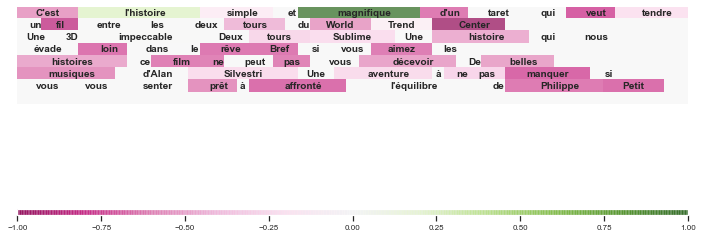

BILSTM CNN
Proba class 1 : 0.9988376498222351


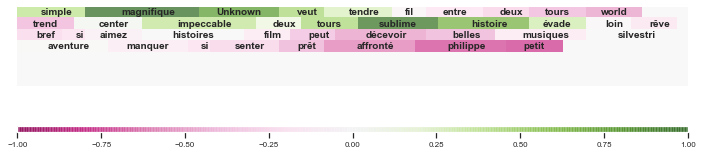

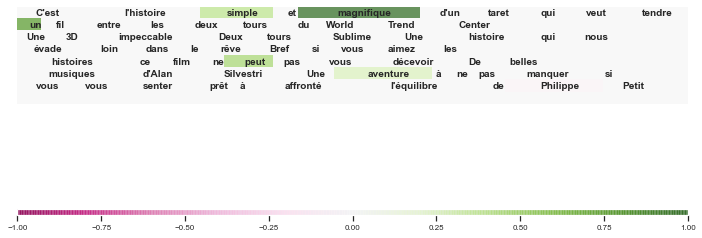



18592
True label : 1


Ce film est "LE" thriller pour ado par excellence. Dommage que les suites sont aussi ridicules que les producteurs qui les ont imaginés.


CNN Character level
Proba class 1 : 0.010403422638773918


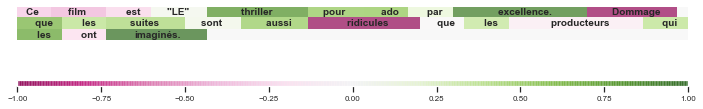

Embed CNN
Proba class 1 : 0.023062819615006447


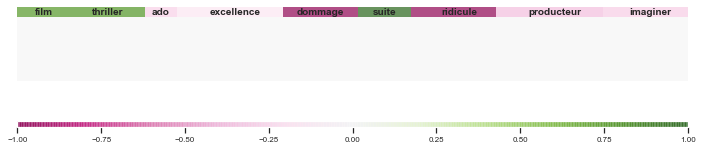

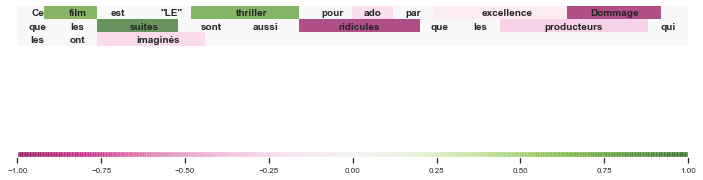

BILSTM CNN
Proba class 1 : 0.0352066233754158


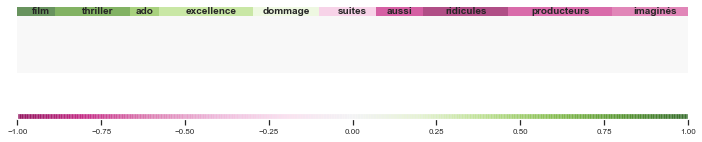

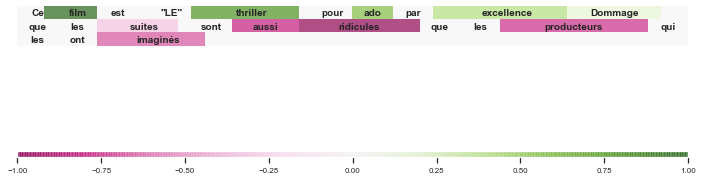



17477
True label : 1


Complètement outrancier, beauf, lamentable... Bref, excellent ! Par contre, à ne pas mettre entre toutes les mains tant c'est grossier et dégueu à tous les niveaux...


CNN Character level
Proba class 1 : 0.8807311058044434


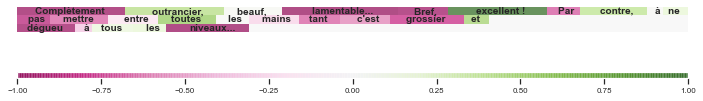

Embed CNN
Proba class 1 : 0.6274962425231934


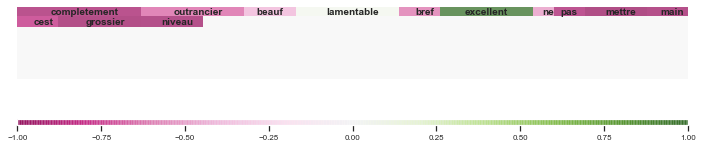

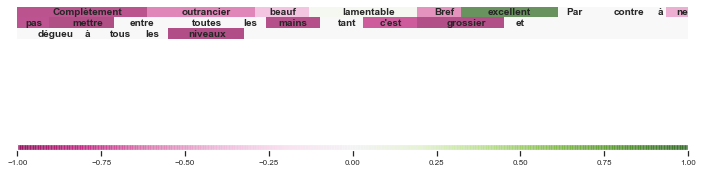

BILSTM CNN
Proba class 1 : 0.4862571060657501


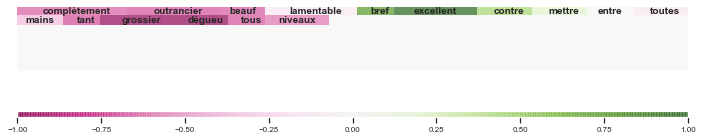

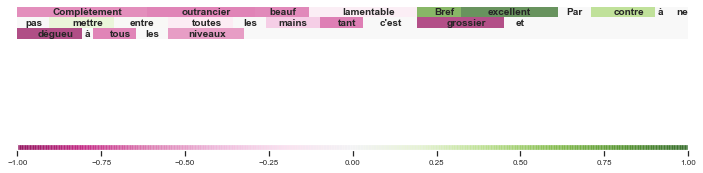



1634
True label : 1


Entre psychologie et fantastique ce thriller nous pique au vif . La tension ne retombe qu' à la fin en apothéose.


CNN Character level
Proba class 1 : 0.9557135105133057


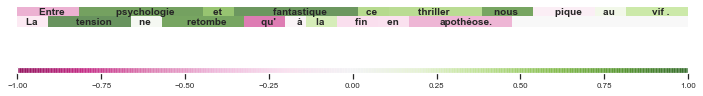

Embed CNN
Proba class 1 : 0.34368419647216797


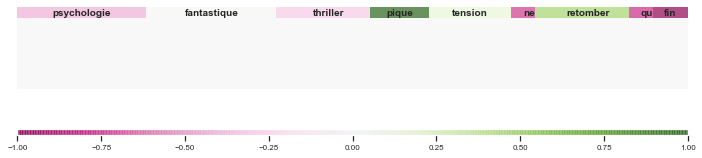

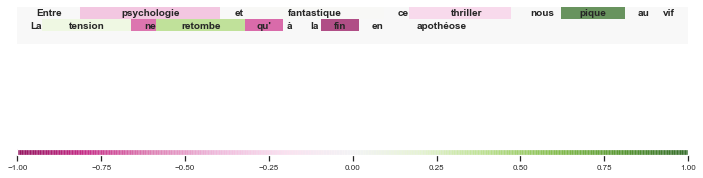

BILSTM CNN
Proba class 1 : 0.9000797271728516


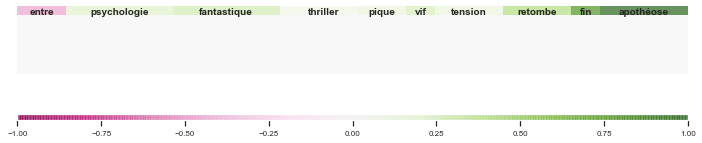

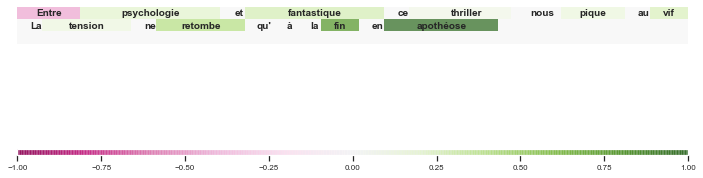



8272
True label : 1


Il semble inutile d'enterrer encore plus ce film mais je ne peux m'en empêcher tellement ce fut lamentable. Film LE plus mauvais que j'ai jamais vu et pourtant j'en ai vu des films. Jeu d'acteur INEXISTANT, performance d'acteur à se faire dessus. A croire que j'ai découvert un nouveau style cinématographique qui m'était inconnu jusque là tellement tout ça paraît surréaliste. Mais il faut reconnaître que c'est le seul à avoir fait un film sur les réseaux pédo-criminels en France à ma connaissance et ça , ça n'a pas de prix. Voilà pourquoi je lui mets 5étoiles et non 0étoile comme il le mérite amplement d'un point de vue objectif selon moi. Regardez le pour vous marrez vous n'allez pas être déçus.Mention spéciale au moment ou Jean-Pierre sauve l'enfant des mains de son ravisseur, ANTHOLOGIQUE ! (léger sourire du gamin, Jean Pierre qui arrive comme si il n'avait jamais fait de cinéma de sa vie bref... INCROYABLE


CNN Character level
Proba class 1 : 0.0239440053701

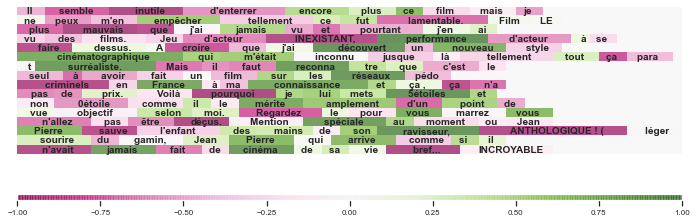

Embed CNN
Proba class 1 : 0.04807848855853081


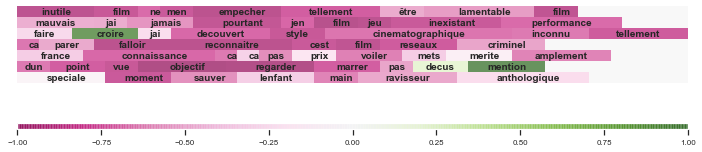

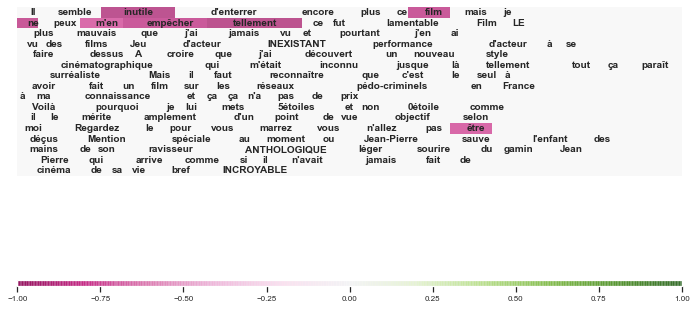

BILSTM CNN
Proba class 1 : 0.0027928093913942575


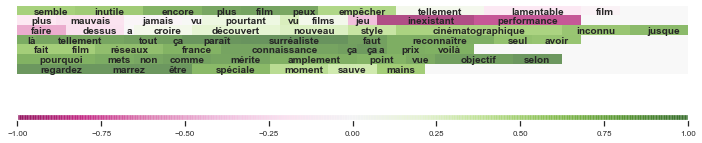

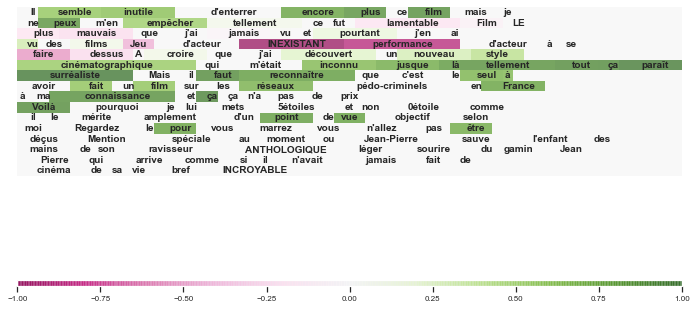



17545
True label : 1


Jack Hill possède quelque chose qui rend ses films et ses personnages attachants.Même si ceux ci ne sont pas campés par des acteurs d'exceptions,il arrive a leur insuffler ce qu"il faut pour les suivres avec intérêt.Cette histoire de gangs en surface est surtout une mise en abyme de jeunes paumés dans leur milieu.La vie de ces jeunes femmes qui n'ont pas d'autre choix qu’être aussi forte que des hommes.Hill mani plutôt avec habilité ses personnages féminins sans pour autant les faires tombés dans un discourt féministe bateau.C'est un mix entre un film d'exploitation,et une critique social,le résultat et un savoureux mélange des genre et des émotions.


CNN Character level
Proba class 1 : 0.1540183275938034


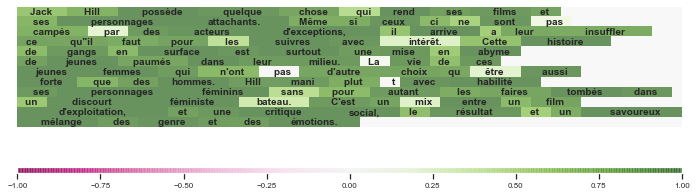

Embed CNN
Proba class 1 : 0.8106279373168945


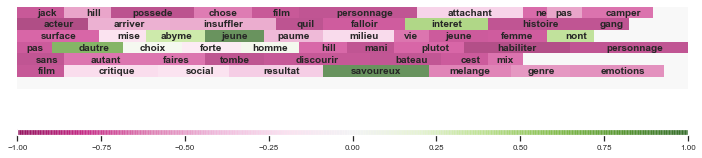

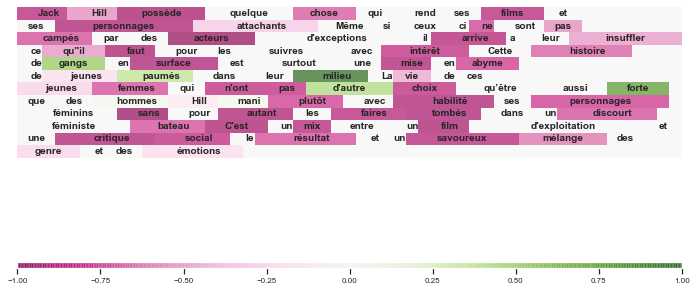

BILSTM CNN
Proba class 1 : 0.9695911407470703


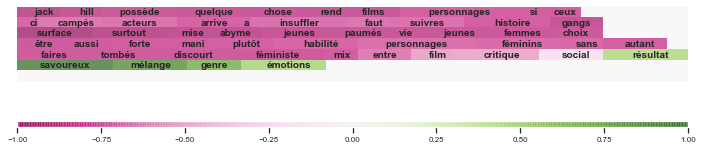

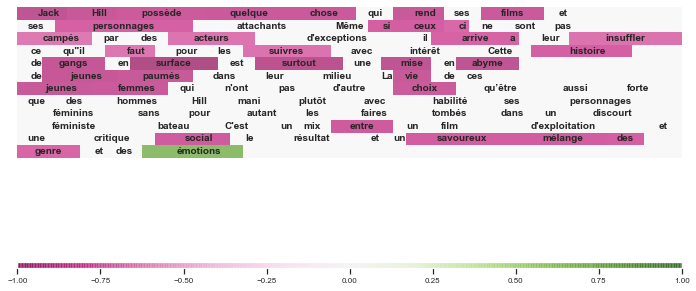



5411
True label : 0


Je ne peux pas dire que j'ai détesté ni même dire que j'ai adoré. L'histoire est introduite sans douceur, il n'y a pas vraiment de début (et de fin ?), trop de passages restent inexpliqués, des longueurs se font sentir, mais à côté les acteurs font sincères et les musiques envoutantes. La scène de transe est quand même un brin soporiphique. Donc deux étoiles mais à choisir j'aurais mis entre une et deux étoiles.


CNN Character level
Proba class 1 : 0.3538808524608612


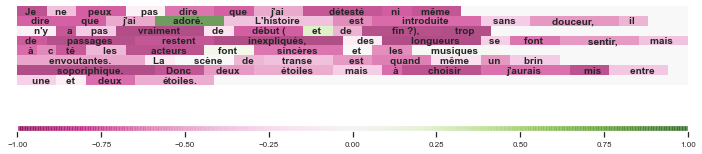

Embed CNN
Proba class 1 : 0.506394624710083


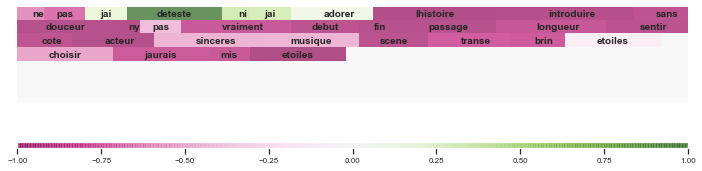

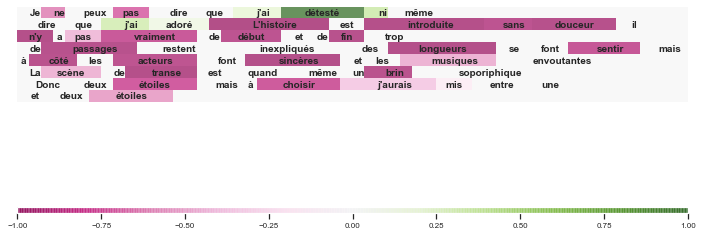

BILSTM CNN
Proba class 1 : 0.3866598904132843


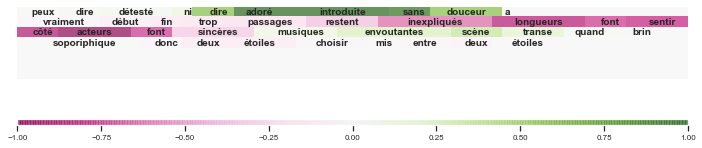

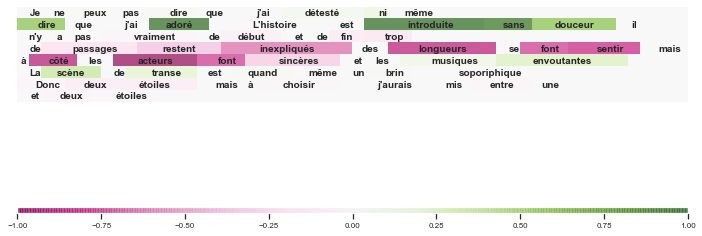



8463
True label : 1


Je pense que ce film doit être apprécié dans l'ensemble de la saga. Seul, ce film est banal et sans doute serait une deception. Par contre une fois mis dans l'ensemble de la saga, cela améliore les choses. Encore une fois un nouveau film cloverfield qui ne ressemble pas aux 2 autres. Je trouve que cela vaut la peine de les voir. Ok c'est pas un gros AAA mais cela n'a jamais été l'ambition des producteurs. Il y a à ma connaissance très peu de saga qui traite "le fil rouge de la saga" de la sorte. Je trouve que ce concept est original. La saga "l'invasion du monde par des monstres" n'est qu'un pretexte, un décor pour raconter des histoires (La fête d'anniversaire filmée avec des smartphones qui tourne mal, le kdinaping dans un bunker ou l'experience scientifique qui tourne mal J'ai hate de voir le 4


CNN Character level
Proba class 1 : 0.3525858521461487


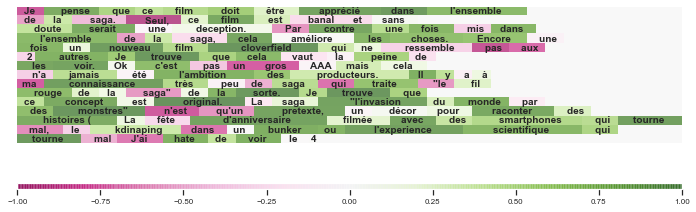

Embed CNN
Proba class 1 : 0.0056235287338495255


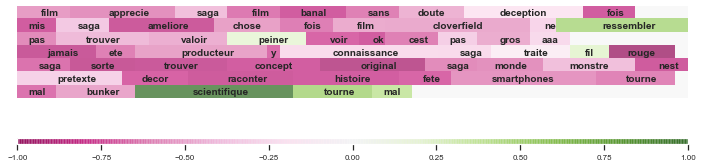

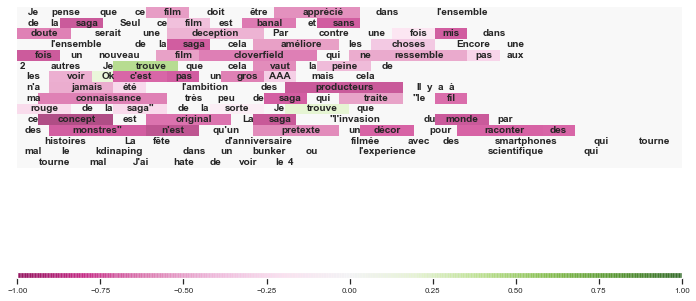

BILSTM CNN
Proba class 1 : 0.04010598734021187


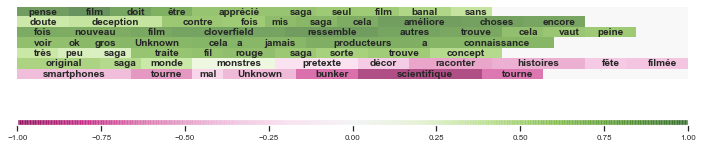

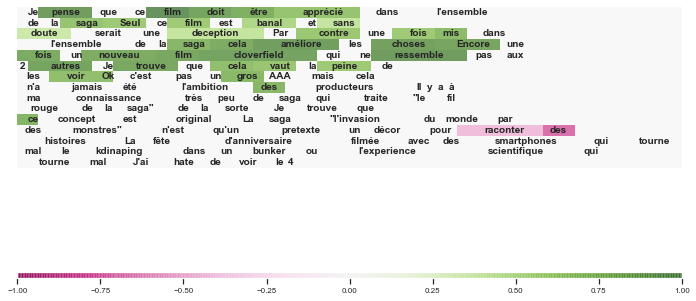



12147
True label : 1


Premier long-métrage de Nicolas Winding Refn et premier volet d'une trilogie devenue culte, Pusher raconte la semaine cauchemardesque d'une petite frappe de Copenhague victime de son mauvais karma. Réalisé de manière très crade, caméra à l'épaule, le film fait tout pour nous faire ressentir au plus près le morne quotidien de son personnage principal. L'immersion est complètement réussie: rarement la triste réalité de la délinquance n'a été décrite avec aussi peu d'enrobage au cinéma. Un peu handicapé par un scénario cousu de fil blanc, ce "Mean Street à la sauce danoise" vaut surtout par son ambiance d'une noirceur étouffante et par l'efficacité de sa narration.


CNN Character level
Proba class 1 : 0.9436203837394714


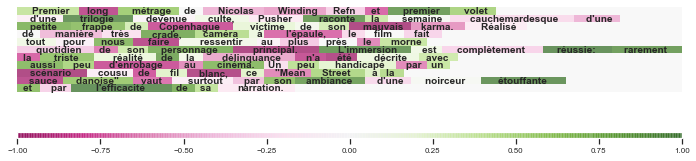

Embed CNN
Proba class 1 : 0.23146454989910126


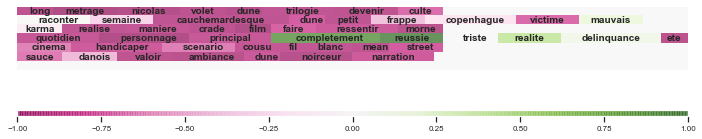

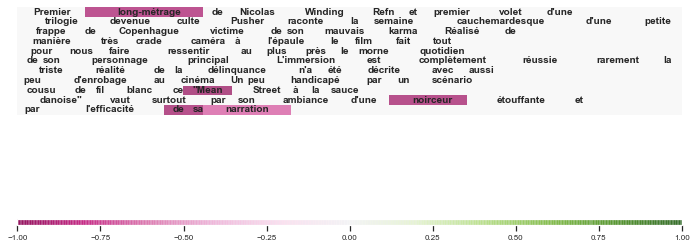

BILSTM CNN
Proba class 1 : 0.6704649329185486


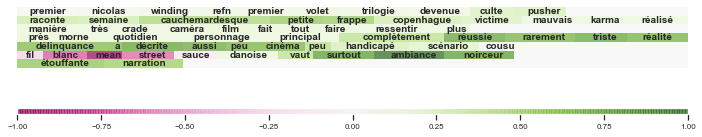

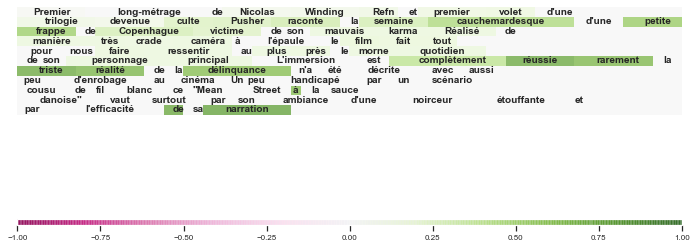



4763
True label : 1


Très bon film de Nicolas Winding Refn, qui sera le premier de la trilogie Pusher s'étalent de 1996 à 2005. L'histoire de Frank et de son ami Tony relate l'histoire super violente de petits dealers de Copenhague. Frank vend de l'héroïne et fréquente le milieu de la petite criminalité. Au cours d'une livraison qui tourne mal, celui-ci se fait arrêter par la police avant de se débarrasser de la marchandise. Ce dernier relâché, n'ayant plus la marchandise ni l'argent à une grosse dette envers Milo, trafiquant serbe notoire. Frank, alors aux abois, va alors par tout les moyens, tentait de récupérer de l'argent s'engouffrant au fur et à mesure dans une spirale infernale d'une fuite en avant sans fin, transmettant au spectateur, son angoisse, son oppression et son mal être omniprésent.


CNN Character level
Proba class 1 : 0.9984323382377625


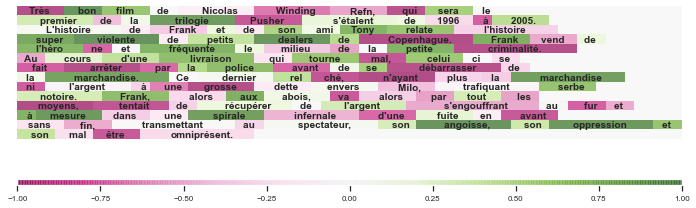

Embed CNN
Proba class 1 : 0.9023676514625549


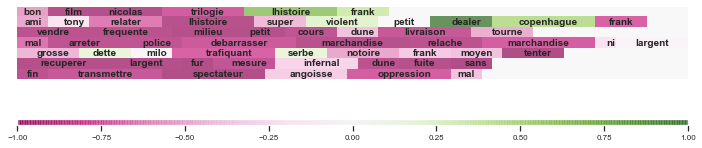

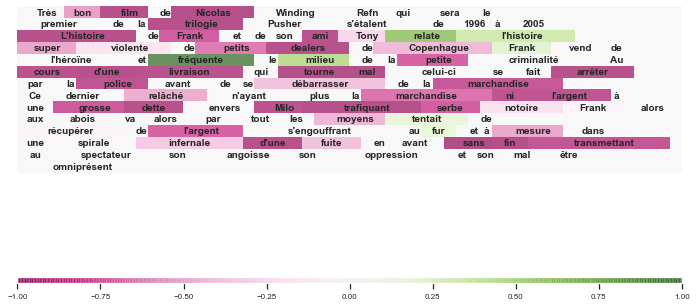

BILSTM CNN
Proba class 1 : 0.9986395239830017


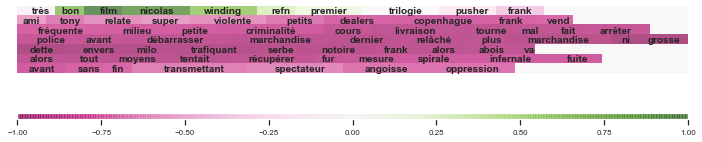

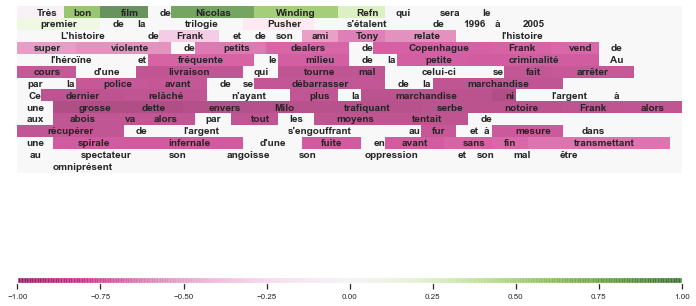



4628
True label : 0


Très déçue par cette 2e partie qui est alourdie par cette lecture qui n'en finit pas, moins d'intérêt que le 1 et 2 et j'hésite à aller voir le 5


CNN Character level
Proba class 1 : 0.0009489775402471423


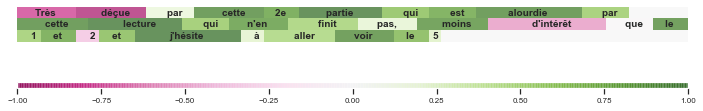

Embed CNN
Proba class 1 : 0.4829058349132538


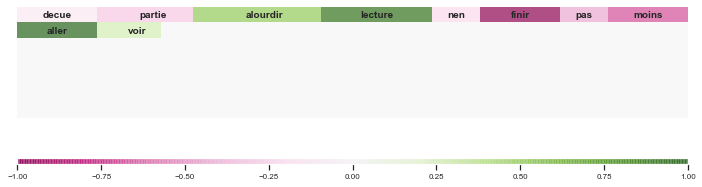

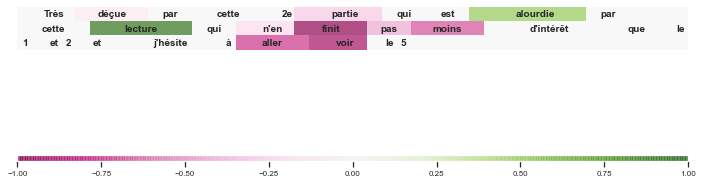

BILSTM CNN
Proba class 1 : 0.004137113690376282


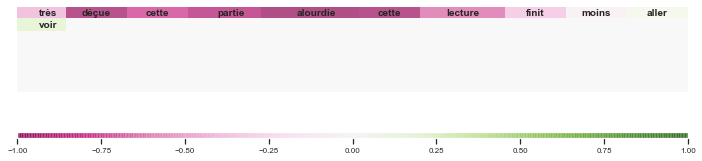

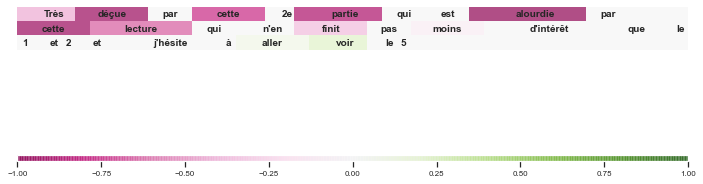



19018
True label : 1


Un film chorale. De très nombreux personnages qui finissent tous par être plus ou moins liés. Le travail scénaristique est énorme et tout cela est bien ficelé. Un divertissement très classe, souvent drôle, avec un nombre incalculable de rebondissements.


CNN Character level
Proba class 1 : 0.9954564571380615


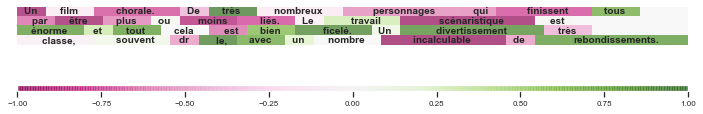

Embed CNN
Proba class 1 : 0.4676845967769623


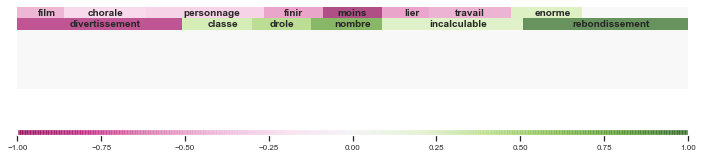

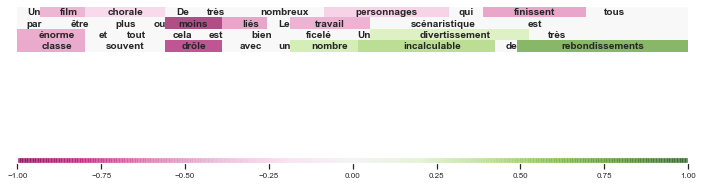

BILSTM CNN
Proba class 1 : 0.8759899139404297


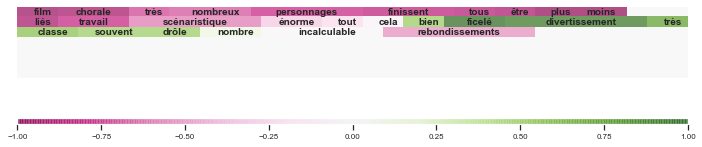

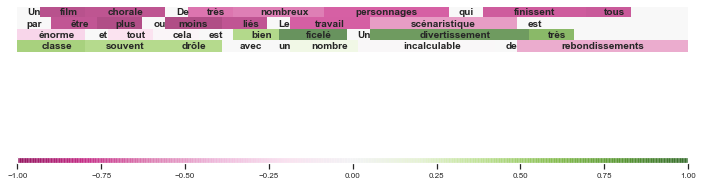



8669
True label : 1


Un film de SF français qui sort de l'ordinaire. Certes on pense beaucoup à The descent et au Dernier combat de Besson. Le début est un peu lent et ennuyeux, on a vite l'envie d'arrêter la vision mais petit à petit on se laisse prendre par une ambiance bien particulière. Il y a une vrai suspens et cela amène pas mal à réfléchir. La fin est plutôt réussi. Un petit film avec un petit budget mais pour beaucoup d'effet(s).


CNN Character level
Proba class 1 : 0.10983065515756607


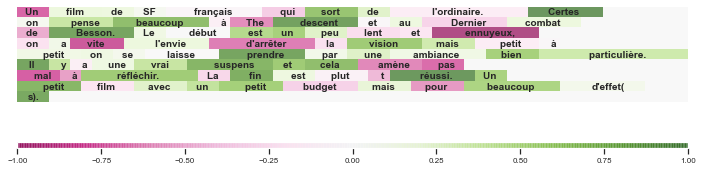

Embed CNN
Proba class 1 : 0.0394180491566658


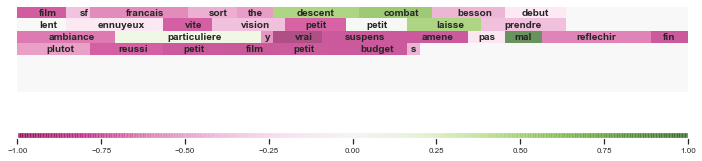

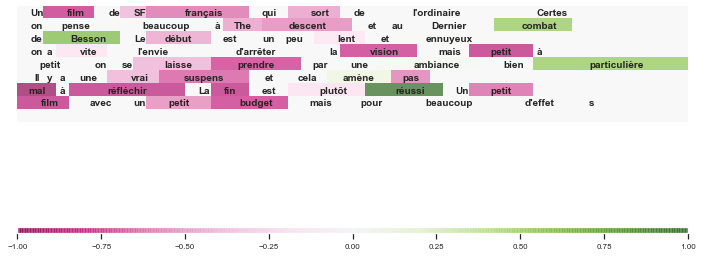

BILSTM CNN
Proba class 1 : 0.7930915355682373


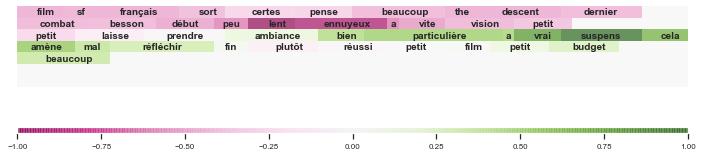

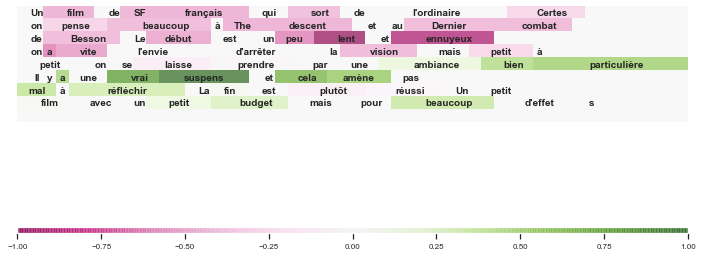



12220
True label : 1


Un film si mauvais que ca en devient cosmique. Tout est raté dans ce film complêtement débil, les dialogues sont mauvais, la mise en scène est affligeante, les acteurs sont ratés, le doublage est pathétique, le scénario n'a aucun sens, les effets spéciaux ont visiblement été travaillés sur paint, la musique (bizarrement pas si nulle) est si mal employée qu'elle fini par énerver. Bref on pourrait chercher longtemps tout ce qui ne va pas dans ce film, mais visiblement les auteurs ont essayé de filmer avec les pieds un projet qu'on oserait pas écrire sur du pq de peur de se salir l'anus, en ce sens ils ont réussis leur pari.


CNN Character level
Proba class 1 : 1.1930511391256005e-05


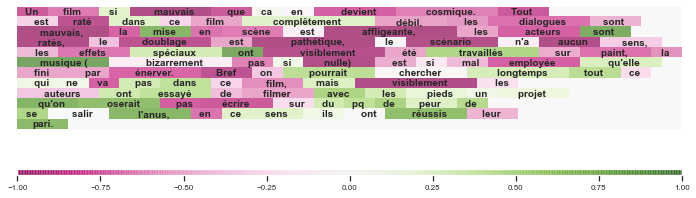

Embed CNN
Proba class 1 : 0.00022575682669412345


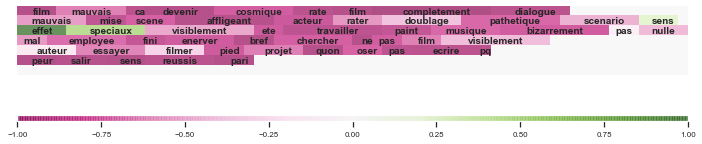

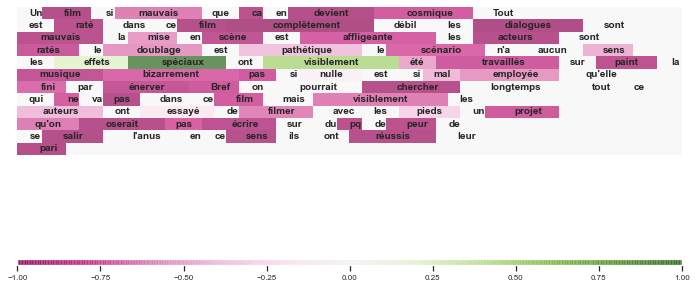

BILSTM CNN
Proba class 1 : 2.3229131329571828e-05


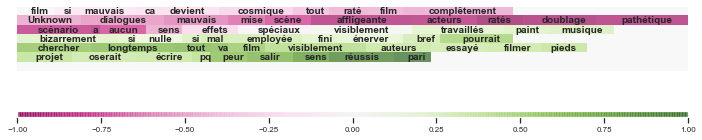

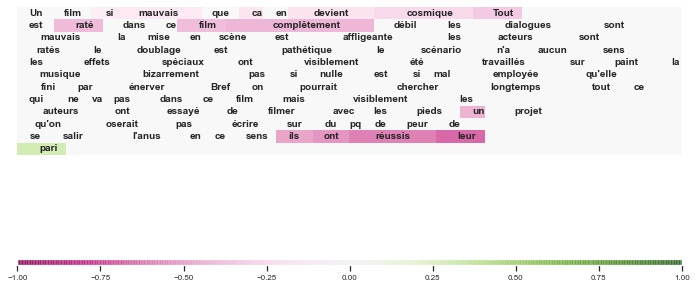



7086
True label : 0


Un pure chef d'oeuvre du 7ème art que le film avalon nous montre.Un film dont la musiques et l'action sont de bonnes qualitées et qu'il n'est à manquer sous aucun prétexte. EXCELLENT à voir un film avoir en dvd.


CNN Character level
Proba class 1 : 0.9971277117729187


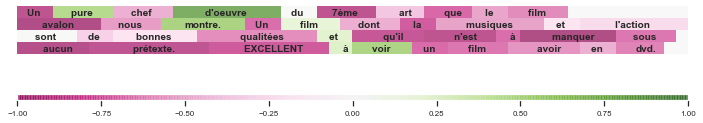

Embed CNN
Proba class 1 : 0.9902825355529785


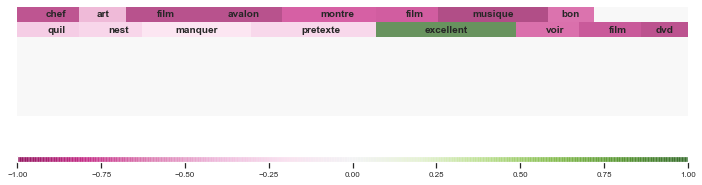

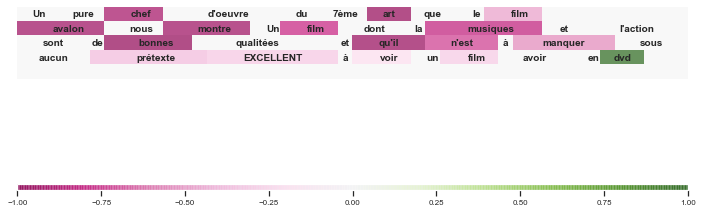

BILSTM CNN
Proba class 1 : 0.9982613921165466


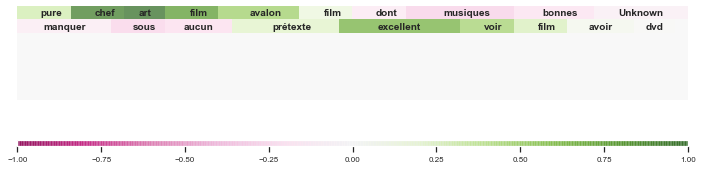

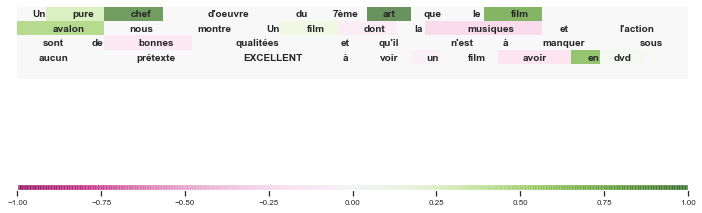



13266
True label : 1


Voilà un bon film, au propos très intéressant bien que parfois grossier. On y voit les "affaires" pas toujours claires de ceux qui nous gouvernent, leur connivence avec les médias, et dans certains cas leur pouvoir de censure. Un film assez pertinent mais pourtant très méconnu, sans doute qu'il dérange...


CNN Character level
Proba class 1 : 0.541659951210022


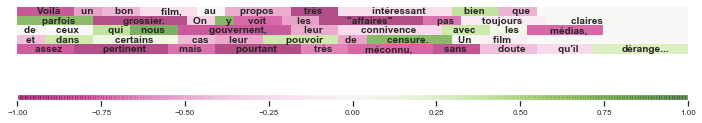

Embed CNN
Proba class 1 : 0.8200972080230713


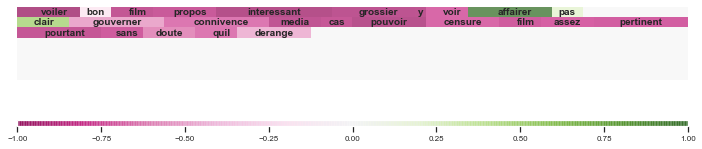

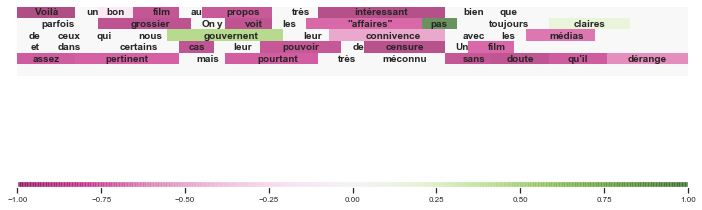

BILSTM CNN
Proba class 1 : 0.9948264956474304


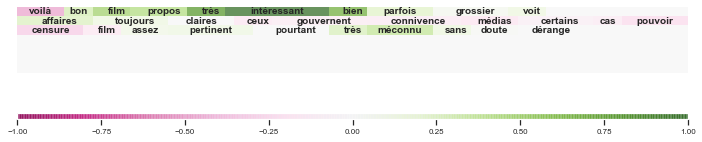

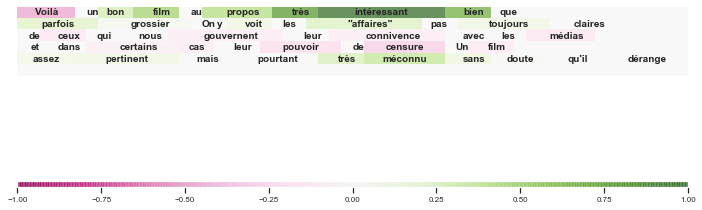



18237
True label : 1


une comédie horrifique très drole mais très mal fait le bonhomme de neige !!! il est en mousse en fait. sinon le film est bien gore, les acteurs ne sont pas vraiment mauvais, l'humour est bien semé... bref, une bonne rigolade ce film


CNN Character level
Proba class 1 : 0.4507620930671692


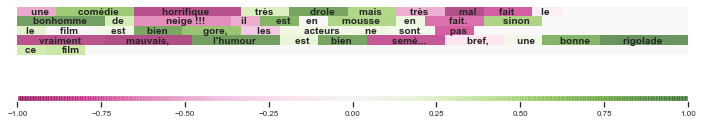

Embed CNN
Proba class 1 : 0.11598379164934158


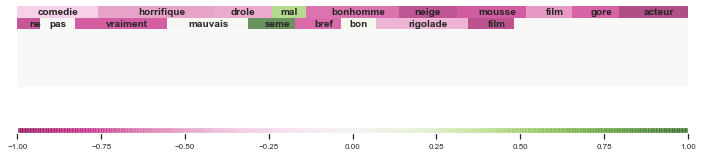

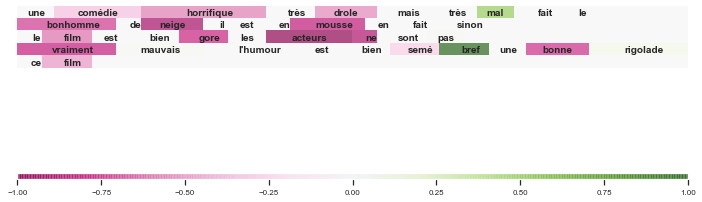

BILSTM CNN
Proba class 1 : 0.9142495393753052


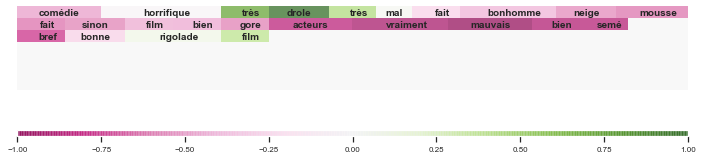

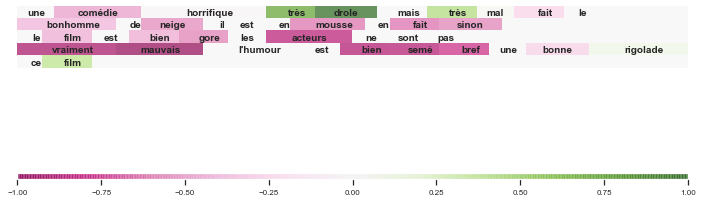

In [102]:
# without threshold
for i in range(index_to_print.shape[0]):
    index= index_to_print[i]
    print("\n")
    print(index)
    print("True label : {}".format(label_data[i]))
    print("\n")
    initial_review= initial_review_tt[index]
    print(initial_review)
    print("\n")
    print_all_model_interpretability(index)



14358
True label : 1


Ah la la,je dois dire que je suis déçu,le film est beaucouptrop court :lol:.Bon je ne dit pas que le film est parfait(Quel que CGI mal fait par ci par la,mais rien de méchant).Le film est clairement un retour a sources des année 80(Que ça soit pour l'action,les méchant très méchant,est les gentil très gentil"enfin quoi que" :D )mais le film est vraiment aider par un second degré constant,il aurait pue faire le film ultra sérieux,mais il on choisie l'option grosse déconade entre pote(Est ce n'est pas plus mal).Bon je vais pas revenir sur le cast(Impressionnant)mais sur leur personnage,si certain on leur rôle bien mis en valeur(Stalone,Statham)d'autre malheureusement mériterai plus(Comme Li ou Lundgren)Est ce que ça nuit au film pour autant :??: certainement pas,le rythme est vraiment soutenue, même quand il y a des passages a vide(Grâce au réplique de chacun est a la bonne humeur que dégage tout les acteur).Les scéne d'action sont vraiment bien huilé(Notamment t

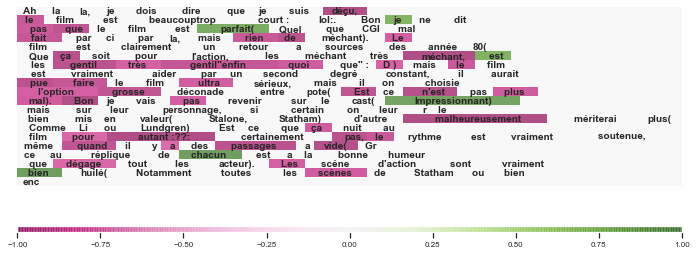

Embed CNN
Proba class 1 : 0.16792473196983337


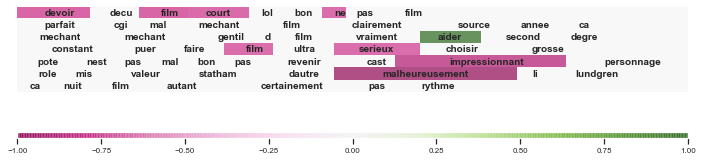

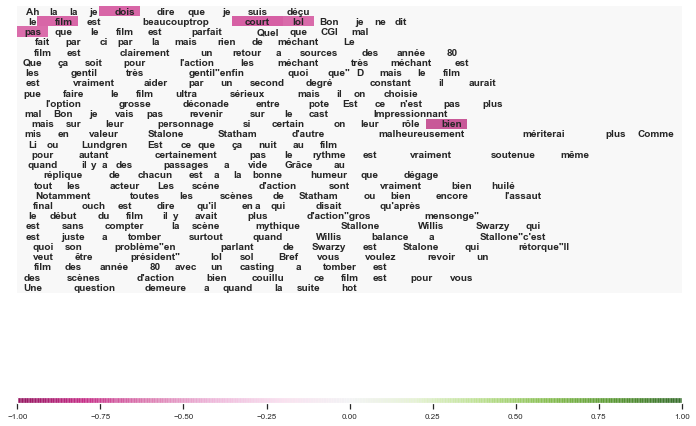

BILSTM CNN
Proba class 1 : 0.39950862526893616


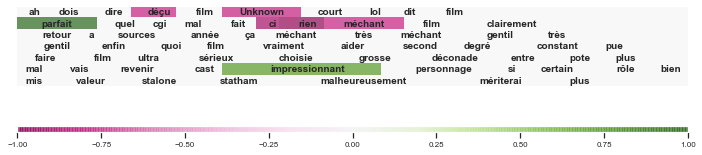

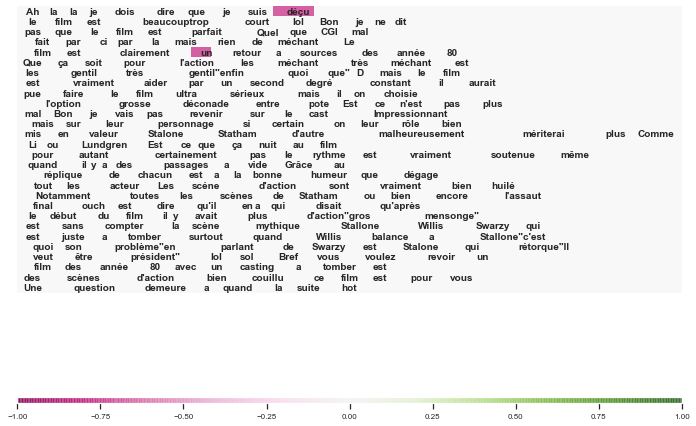



16237
True label : 1


Après le déjà superbe "Mademoiselle" Chambon" (2009) Stephane Brizé revient avec toujours autant de finesse. La promo autour du film s'est focalisé sur le suicide assisté, actualité et débat brûlants aidant, mais je n'ai pas pris ce film sous cet angle. En effet le thème me semble beaucoup plus être la difficulté de communiquer et les liens mère-fils ; ici entre une mère assez rugueuse, amère, plongée dans la solitude et qui se sait condamnée avec un fils qui sort de prison, entre ingratitude maladroite et la réinsertion mal assumée. Le réalisateur use d'une mise en scène tout en pudeur, découpé en plan-séquence qui ajoute au silence pesant tout les subtilités des sentiments. Un film aussi dur et austère que l'est le quotidien des non-dits entre le fils et la mère... Mais aussi et surtout un film d'une belle justesse, non dénué d'une petite note de poésie, bonne inspiration pour atténuer la tragédie qui se profile. Juste un petit bémol pour le personnage du fil

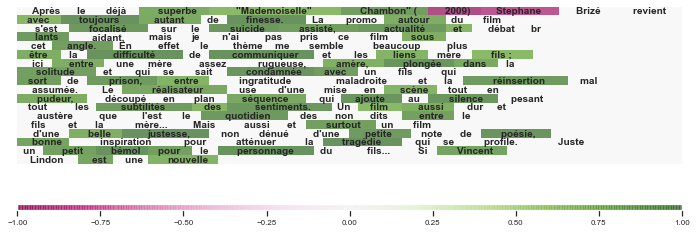

Embed CNN
Proba class 1 : 0.9557337760925293


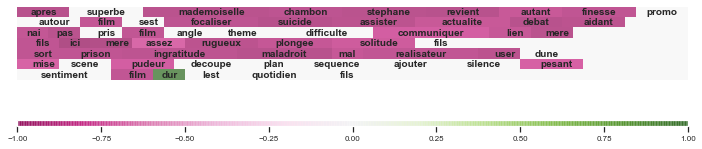

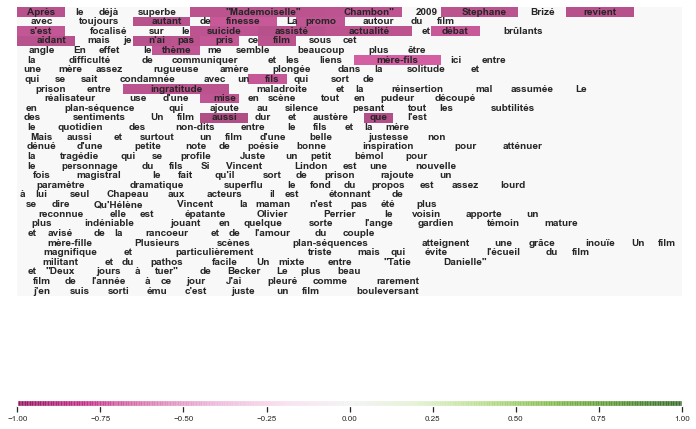

BILSTM CNN
Proba class 1 : 0.9731196761131287


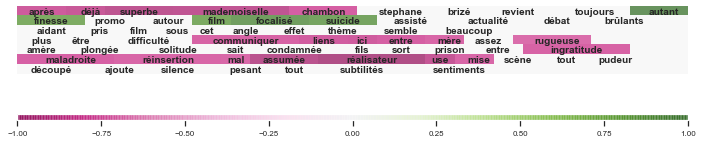

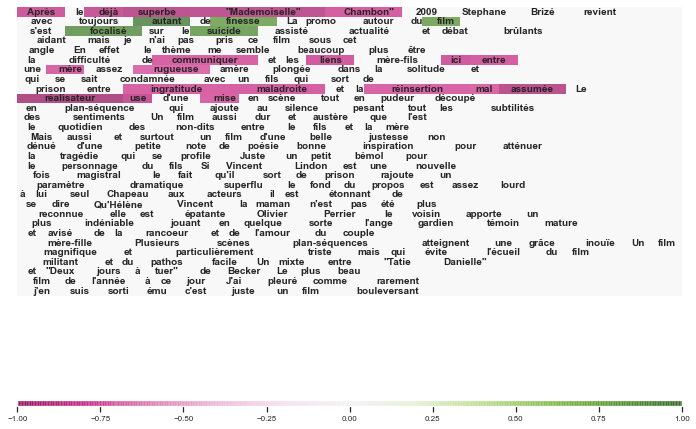



7398
True label : 1


C'est l'histoire simple et magnifique d'un taret qui veut tendre un fil entre les deux tours du World Trend Center. Une 3D impeccable. Deux tours Sublime. Une histoire qui nous évade loin dans le rêve. Bref si vous aimez les histoires ce film ne peut pas vous décevoir De belles musiques d'Alan Silvestri. Une aventure à ne pas manquer si vous vous senter prêt à affronté l'équilibre de Philippe Petit !!!


CNN Character level
Proba class 1 : 0.9959036707878113


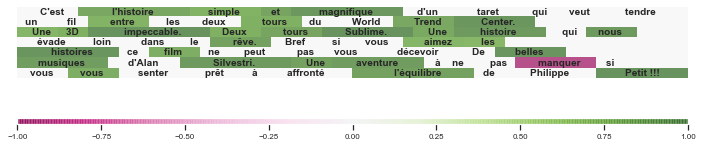

Embed CNN
Proba class 1 : 0.9934533834457397


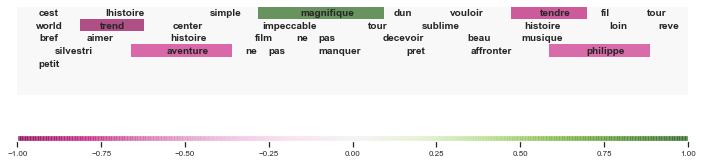

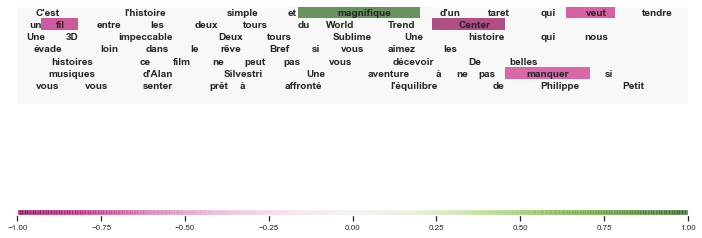

BILSTM CNN
Proba class 1 : 0.9988376498222351


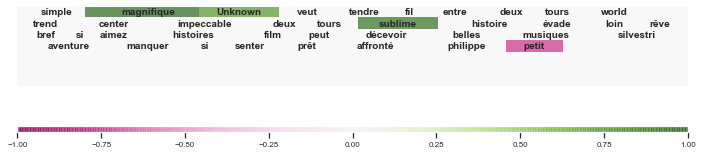

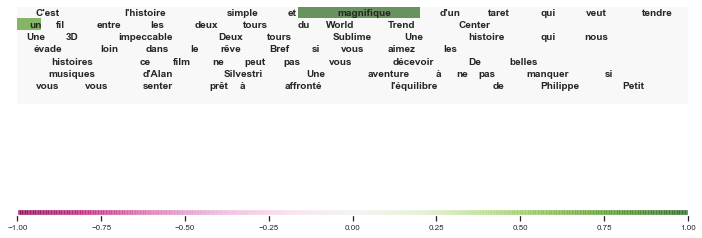



18592
True label : 1


Ce film est "LE" thriller pour ado par excellence. Dommage que les suites sont aussi ridicules que les producteurs qui les ont imaginés.


CNN Character level
Proba class 1 : 0.010403422638773918


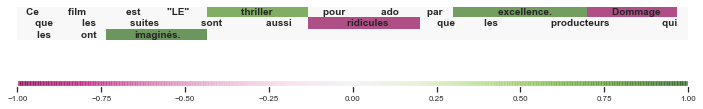

Embed CNN
Proba class 1 : 0.023062819615006447


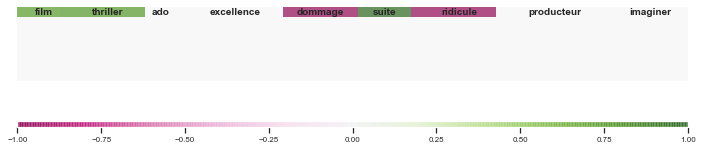

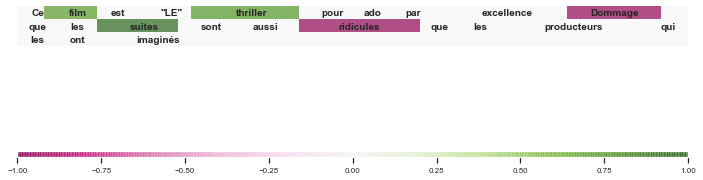

BILSTM CNN
Proba class 1 : 0.0352066233754158


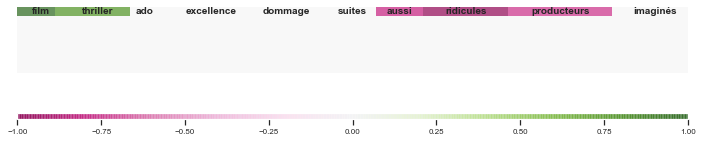

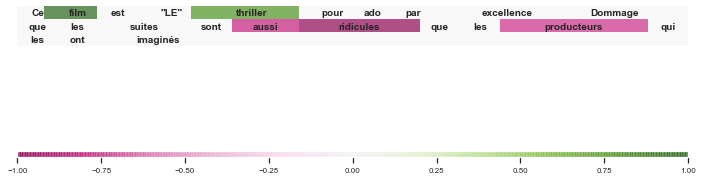



17477
True label : 1


Complètement outrancier, beauf, lamentable... Bref, excellent ! Par contre, à ne pas mettre entre toutes les mains tant c'est grossier et dégueu à tous les niveaux...


CNN Character level
Proba class 1 : 0.8807311058044434


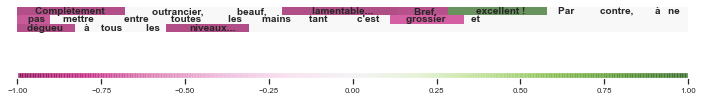

Embed CNN
Proba class 1 : 0.6274962425231934


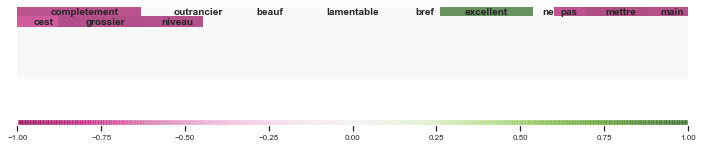

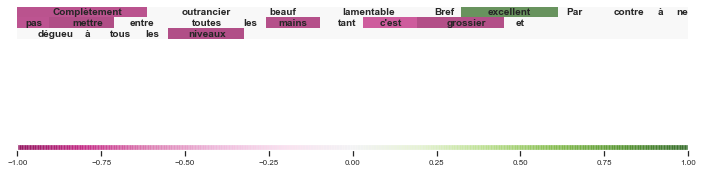

BILSTM CNN
Proba class 1 : 0.4862571060657501


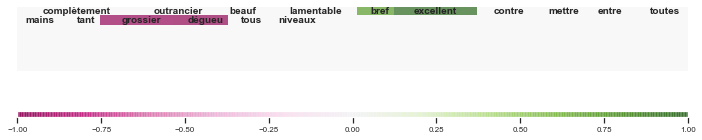

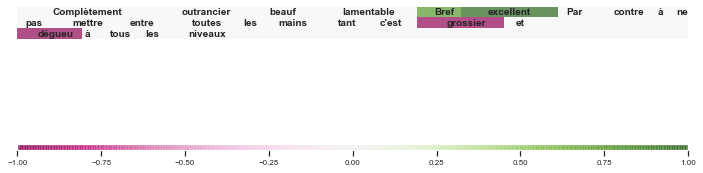



1634
True label : 1


Entre psychologie et fantastique ce thriller nous pique au vif . La tension ne retombe qu' à la fin en apothéose.


CNN Character level
Proba class 1 : 0.9557135105133057


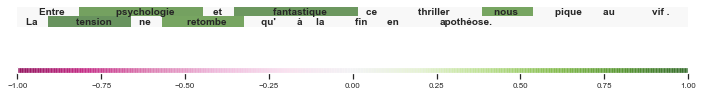

Embed CNN
Proba class 1 : 0.34368419647216797


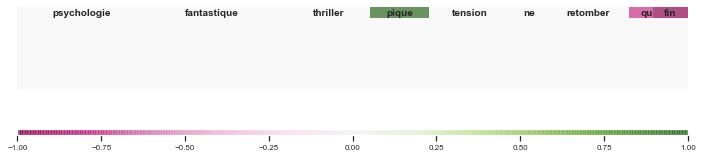

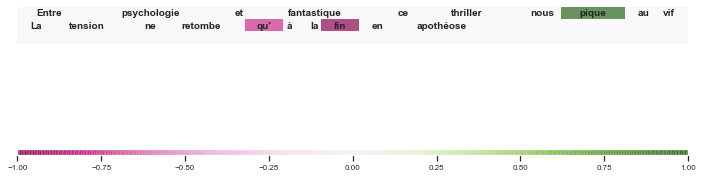

BILSTM CNN
Proba class 1 : 0.9000797271728516


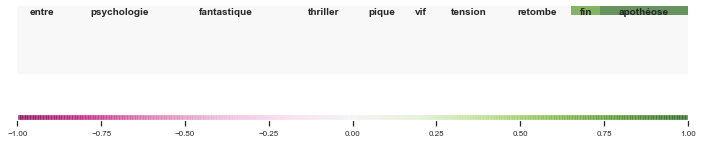

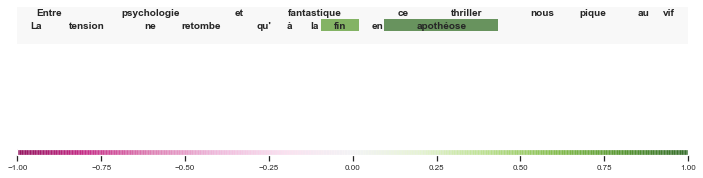



8272
True label : 1


Il semble inutile d'enterrer encore plus ce film mais je ne peux m'en empêcher tellement ce fut lamentable. Film LE plus mauvais que j'ai jamais vu et pourtant j'en ai vu des films. Jeu d'acteur INEXISTANT, performance d'acteur à se faire dessus. A croire que j'ai découvert un nouveau style cinématographique qui m'était inconnu jusque là tellement tout ça paraît surréaliste. Mais il faut reconnaître que c'est le seul à avoir fait un film sur les réseaux pédo-criminels en France à ma connaissance et ça , ça n'a pas de prix. Voilà pourquoi je lui mets 5étoiles et non 0étoile comme il le mérite amplement d'un point de vue objectif selon moi. Regardez le pour vous marrez vous n'allez pas être déçus.Mention spéciale au moment ou Jean-Pierre sauve l'enfant des mains de son ravisseur, ANTHOLOGIQUE ! (léger sourire du gamin, Jean Pierre qui arrive comme si il n'avait jamais fait de cinéma de sa vie bref... INCROYABLE


CNN Character level
Proba class 1 : 0.0239440053701

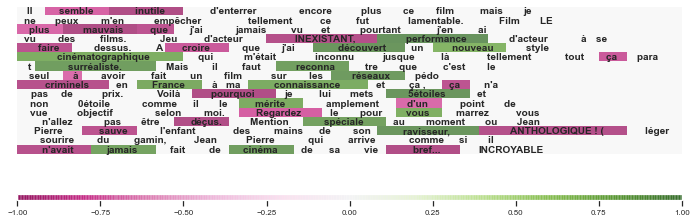

Embed CNN
Proba class 1 : 0.04807848855853081


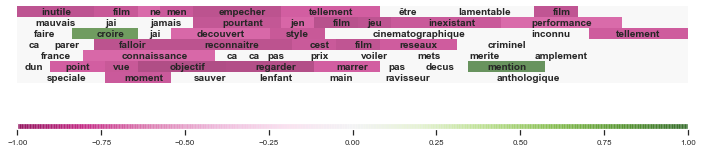

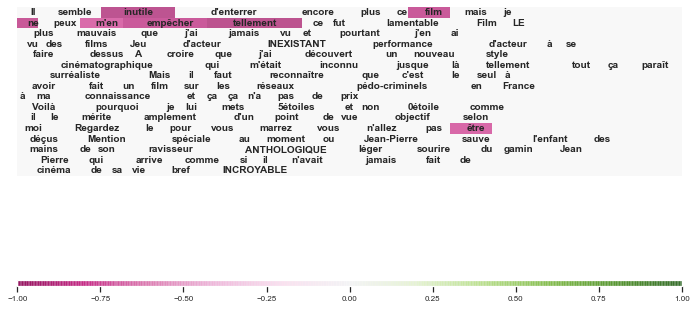

BILSTM CNN
Proba class 1 : 0.0027928093913942575


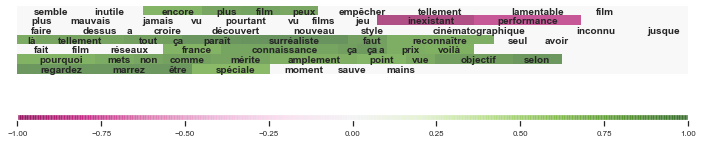

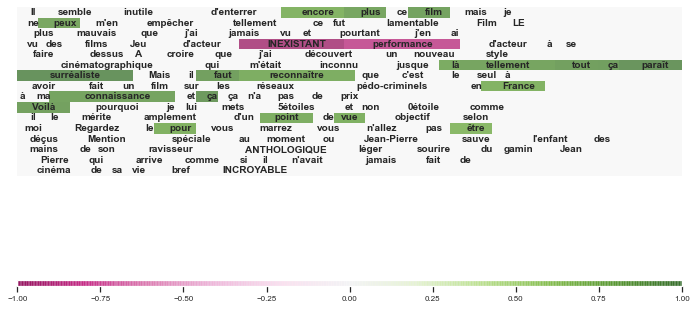



17545
True label : 1


Jack Hill possède quelque chose qui rend ses films et ses personnages attachants.Même si ceux ci ne sont pas campés par des acteurs d'exceptions,il arrive a leur insuffler ce qu"il faut pour les suivres avec intérêt.Cette histoire de gangs en surface est surtout une mise en abyme de jeunes paumés dans leur milieu.La vie de ces jeunes femmes qui n'ont pas d'autre choix qu’être aussi forte que des hommes.Hill mani plutôt avec habilité ses personnages féminins sans pour autant les faires tombés dans un discourt féministe bateau.C'est un mix entre un film d'exploitation,et une critique social,le résultat et un savoureux mélange des genre et des émotions.


CNN Character level
Proba class 1 : 0.1540183275938034


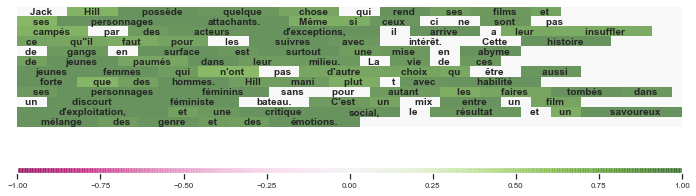

Embed CNN
Proba class 1 : 0.8106279373168945


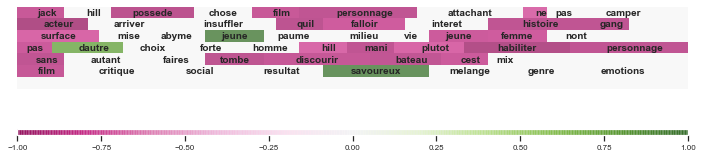

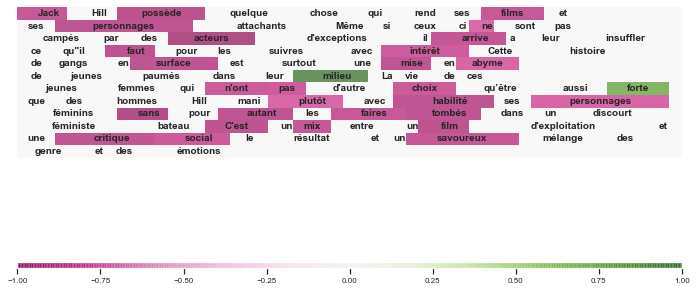

BILSTM CNN
Proba class 1 : 0.9695911407470703


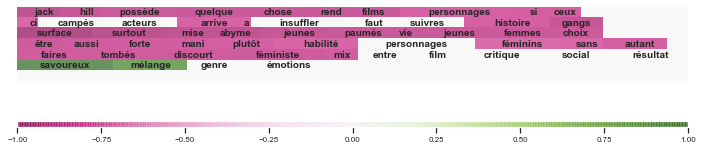

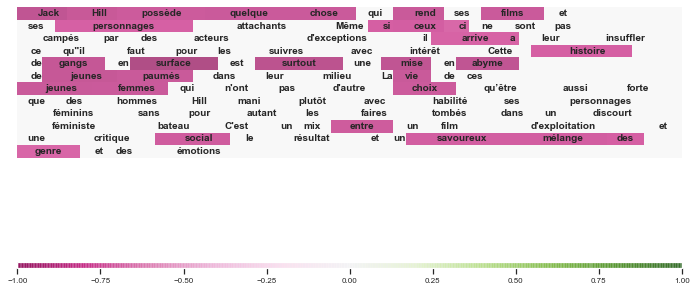



5411
True label : 0


Je ne peux pas dire que j'ai détesté ni même dire que j'ai adoré. L'histoire est introduite sans douceur, il n'y a pas vraiment de début (et de fin ?), trop de passages restent inexpliqués, des longueurs se font sentir, mais à côté les acteurs font sincères et les musiques envoutantes. La scène de transe est quand même un brin soporiphique. Donc deux étoiles mais à choisir j'aurais mis entre une et deux étoiles.


CNN Character level
Proba class 1 : 0.3538808524608612


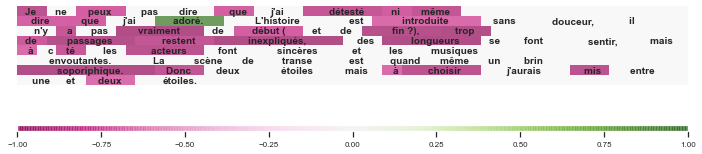

Embed CNN
Proba class 1 : 0.506394624710083


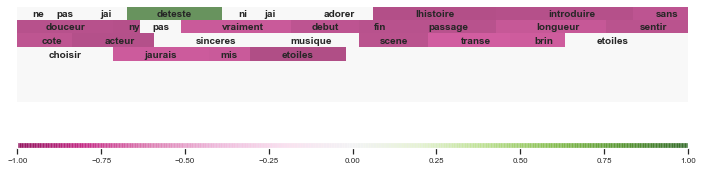

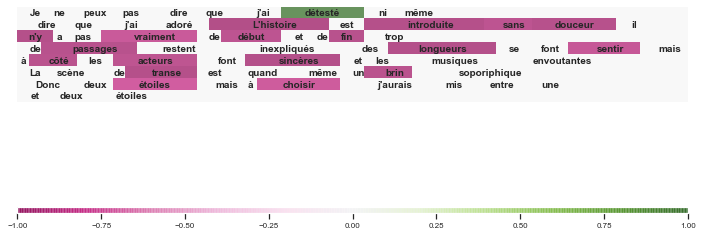

BILSTM CNN
Proba class 1 : 0.3866598904132843


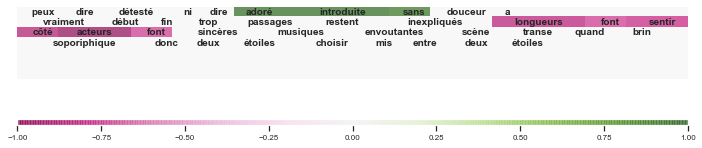

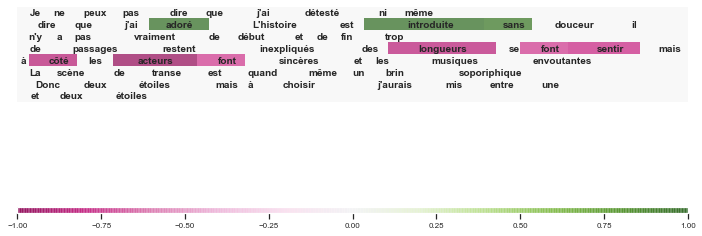



8463
True label : 1


Je pense que ce film doit être apprécié dans l'ensemble de la saga. Seul, ce film est banal et sans doute serait une deception. Par contre une fois mis dans l'ensemble de la saga, cela améliore les choses. Encore une fois un nouveau film cloverfield qui ne ressemble pas aux 2 autres. Je trouve que cela vaut la peine de les voir. Ok c'est pas un gros AAA mais cela n'a jamais été l'ambition des producteurs. Il y a à ma connaissance très peu de saga qui traite "le fil rouge de la saga" de la sorte. Je trouve que ce concept est original. La saga "l'invasion du monde par des monstres" n'est qu'un pretexte, un décor pour raconter des histoires (La fête d'anniversaire filmée avec des smartphones qui tourne mal, le kdinaping dans un bunker ou l'experience scientifique qui tourne mal J'ai hate de voir le 4


CNN Character level
Proba class 1 : 0.3525858521461487


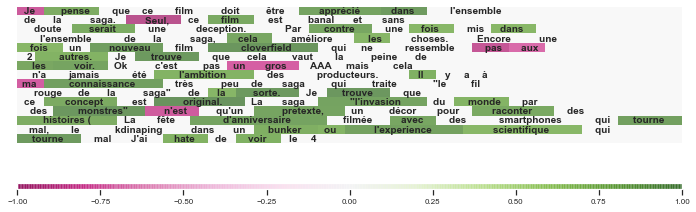

Embed CNN
Proba class 1 : 0.0056235287338495255


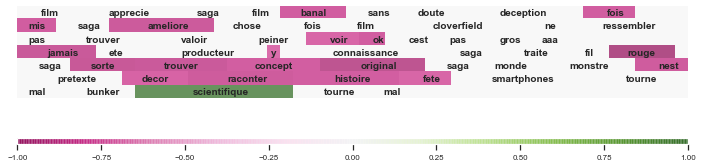

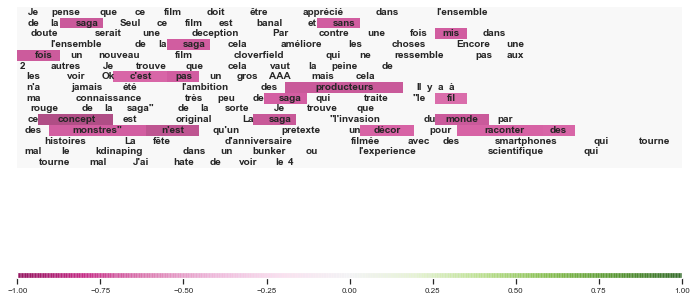

BILSTM CNN
Proba class 1 : 0.04010598734021187


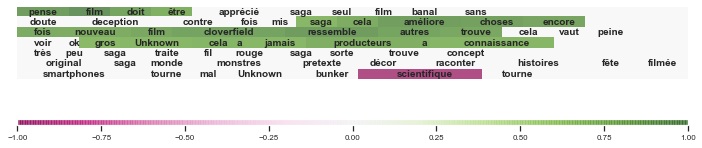

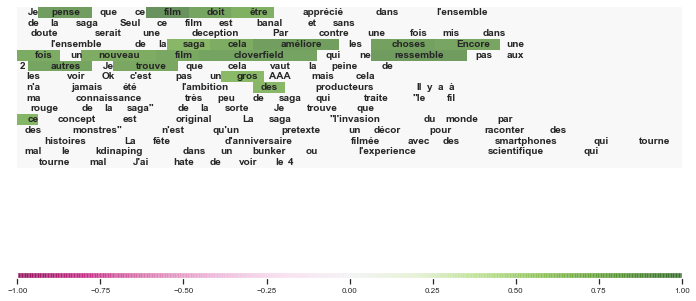



12147
True label : 1


Premier long-métrage de Nicolas Winding Refn et premier volet d'une trilogie devenue culte, Pusher raconte la semaine cauchemardesque d'une petite frappe de Copenhague victime de son mauvais karma. Réalisé de manière très crade, caméra à l'épaule, le film fait tout pour nous faire ressentir au plus près le morne quotidien de son personnage principal. L'immersion est complètement réussie: rarement la triste réalité de la délinquance n'a été décrite avec aussi peu d'enrobage au cinéma. Un peu handicapé par un scénario cousu de fil blanc, ce "Mean Street à la sauce danoise" vaut surtout par son ambiance d'une noirceur étouffante et par l'efficacité de sa narration.


CNN Character level
Proba class 1 : 0.9436203837394714


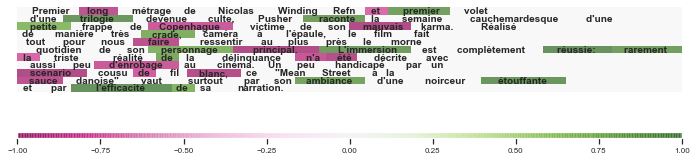

Embed CNN
Proba class 1 : 0.23146454989910126


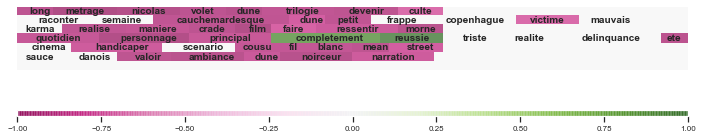

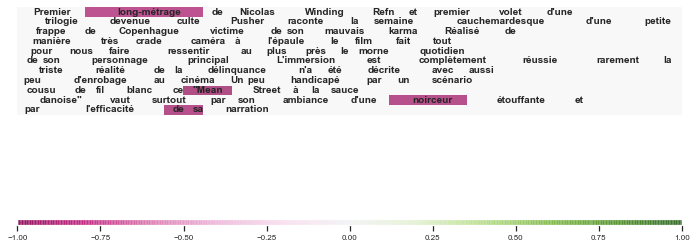

BILSTM CNN
Proba class 1 : 0.6704649329185486


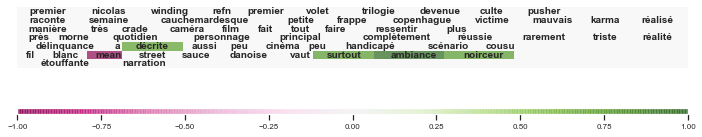

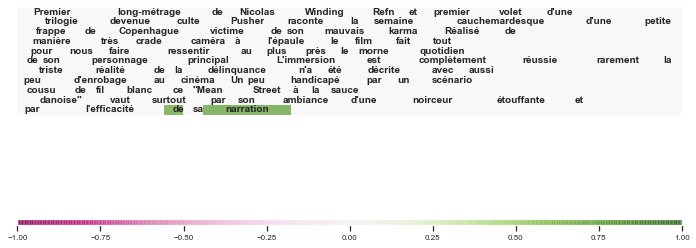



4763
True label : 1


Très bon film de Nicolas Winding Refn, qui sera le premier de la trilogie Pusher s'étalent de 1996 à 2005. L'histoire de Frank et de son ami Tony relate l'histoire super violente de petits dealers de Copenhague. Frank vend de l'héroïne et fréquente le milieu de la petite criminalité. Au cours d'une livraison qui tourne mal, celui-ci se fait arrêter par la police avant de se débarrasser de la marchandise. Ce dernier relâché, n'ayant plus la marchandise ni l'argent à une grosse dette envers Milo, trafiquant serbe notoire. Frank, alors aux abois, va alors par tout les moyens, tentait de récupérer de l'argent s'engouffrant au fur et à mesure dans une spirale infernale d'une fuite en avant sans fin, transmettant au spectateur, son angoisse, son oppression et son mal être omniprésent.


CNN Character level
Proba class 1 : 0.9984323382377625


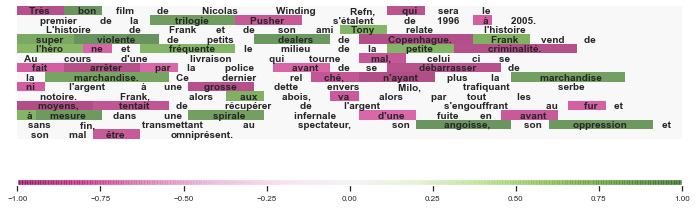

Embed CNN
Proba class 1 : 0.9023676514625549


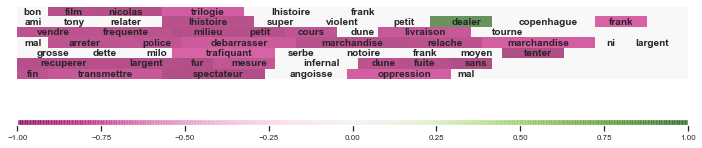

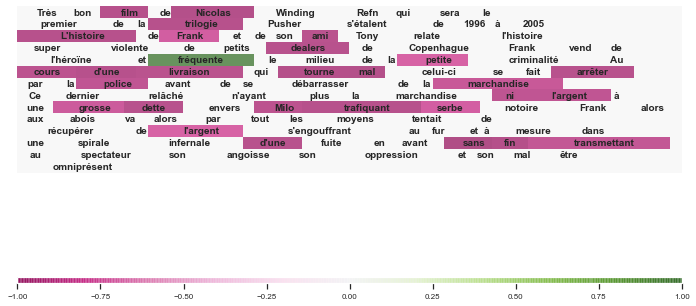

BILSTM CNN
Proba class 1 : 0.9986395239830017


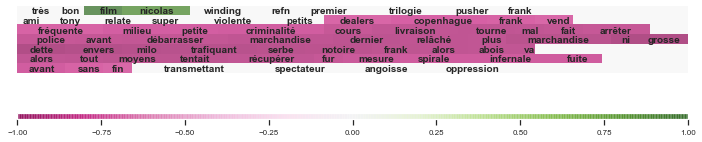

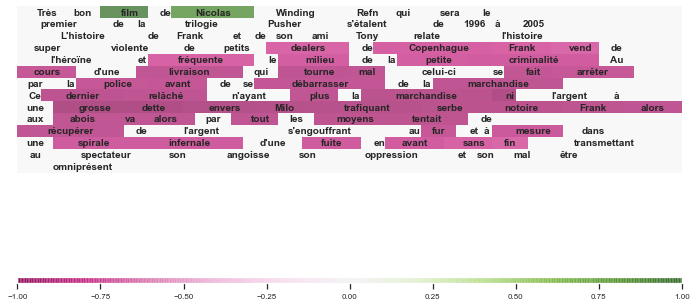



4628
True label : 0


Très déçue par cette 2e partie qui est alourdie par cette lecture qui n'en finit pas, moins d'intérêt que le 1 et 2 et j'hésite à aller voir le 5


CNN Character level
Proba class 1 : 0.0009489775402471423


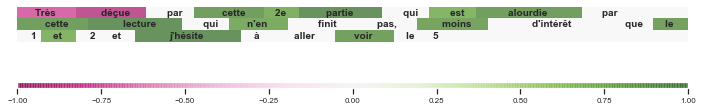

Embed CNN
Proba class 1 : 0.4829058349132538


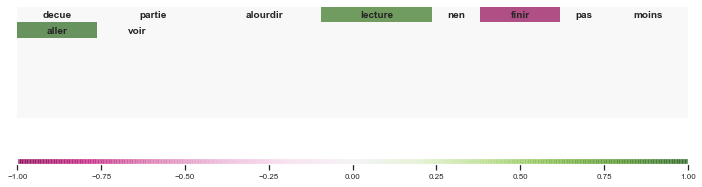

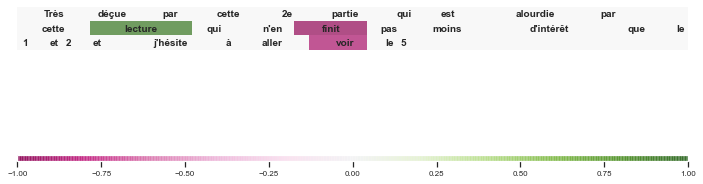

BILSTM CNN
Proba class 1 : 0.004137113690376282


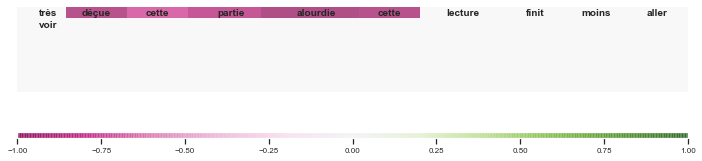

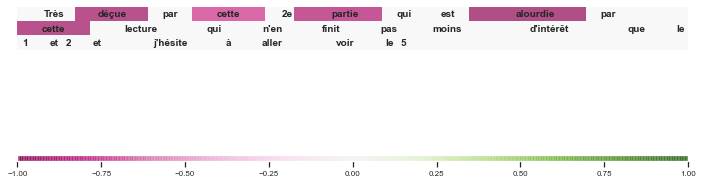



19018
True label : 1


Un film chorale. De très nombreux personnages qui finissent tous par être plus ou moins liés. Le travail scénaristique est énorme et tout cela est bien ficelé. Un divertissement très classe, souvent drôle, avec un nombre incalculable de rebondissements.


CNN Character level
Proba class 1 : 0.9954564571380615


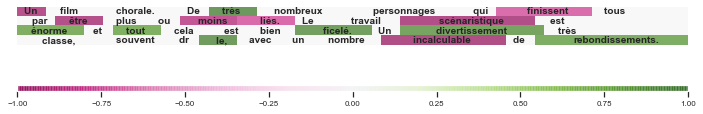

Embed CNN
Proba class 1 : 0.4676845967769623


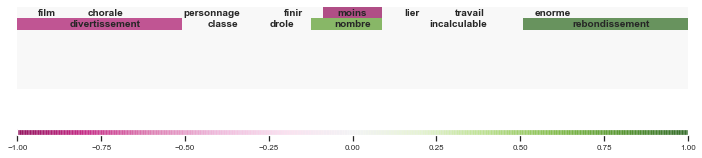

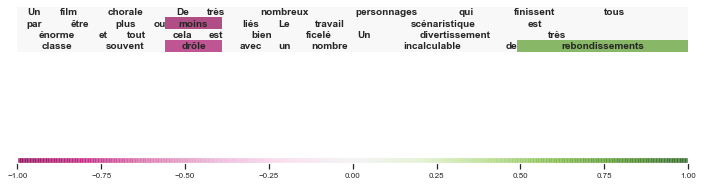

BILSTM CNN
Proba class 1 : 0.8759899139404297


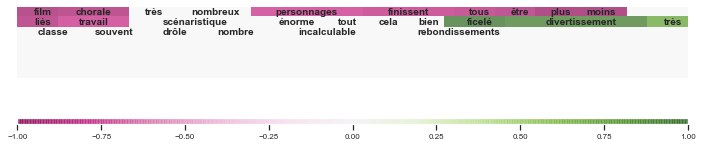

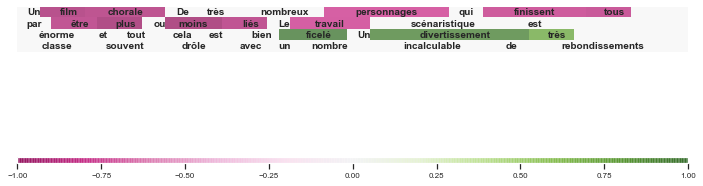



8669
True label : 1


Un film de SF français qui sort de l'ordinaire. Certes on pense beaucoup à The descent et au Dernier combat de Besson. Le début est un peu lent et ennuyeux, on a vite l'envie d'arrêter la vision mais petit à petit on se laisse prendre par une ambiance bien particulière. Il y a une vrai suspens et cela amène pas mal à réfléchir. La fin est plutôt réussi. Un petit film avec un petit budget mais pour beaucoup d'effet(s).


CNN Character level
Proba class 1 : 0.10983065515756607


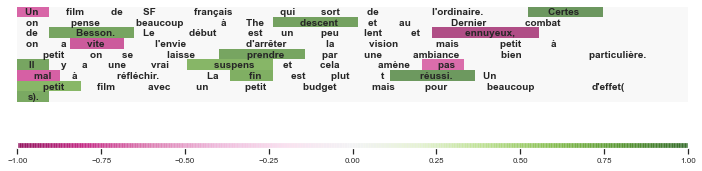

Embed CNN
Proba class 1 : 0.0394180491566658


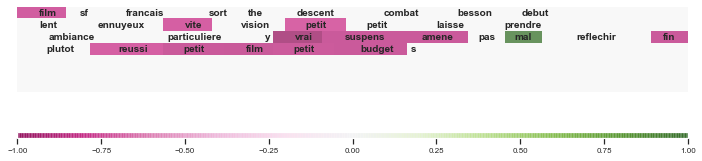

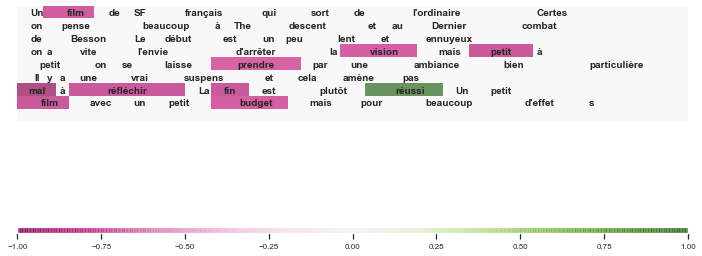

BILSTM CNN
Proba class 1 : 0.7930915355682373


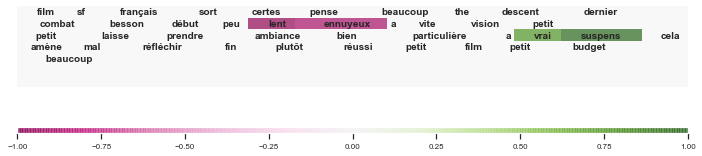

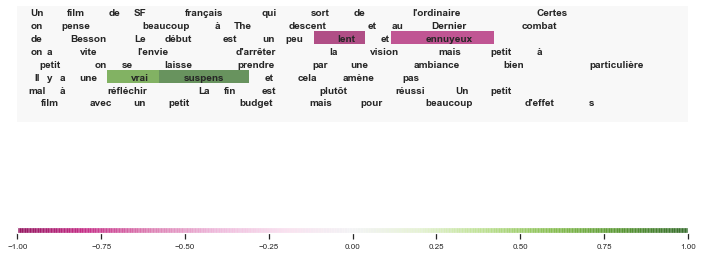



12220
True label : 1


Un film si mauvais que ca en devient cosmique. Tout est raté dans ce film complêtement débil, les dialogues sont mauvais, la mise en scène est affligeante, les acteurs sont ratés, le doublage est pathétique, le scénario n'a aucun sens, les effets spéciaux ont visiblement été travaillés sur paint, la musique (bizarrement pas si nulle) est si mal employée qu'elle fini par énerver. Bref on pourrait chercher longtemps tout ce qui ne va pas dans ce film, mais visiblement les auteurs ont essayé de filmer avec les pieds un projet qu'on oserait pas écrire sur du pq de peur de se salir l'anus, en ce sens ils ont réussis leur pari.


CNN Character level
Proba class 1 : 1.1930511391256005e-05


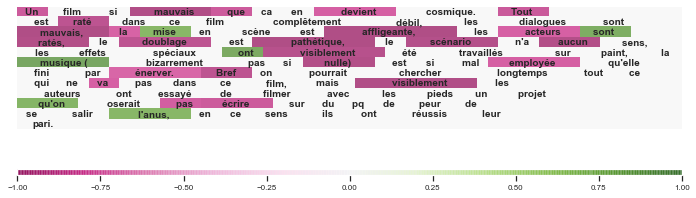

Embed CNN
Proba class 1 : 0.00022575682669412345


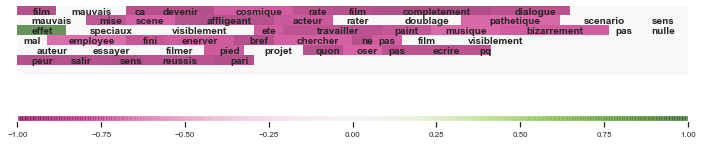

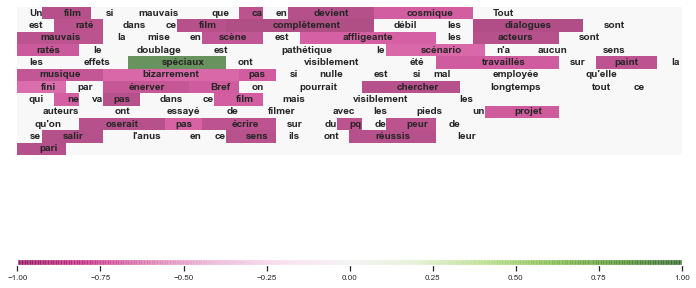

BILSTM CNN
Proba class 1 : 2.3229131329571828e-05


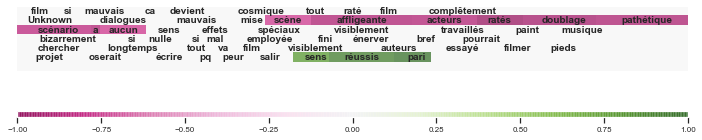

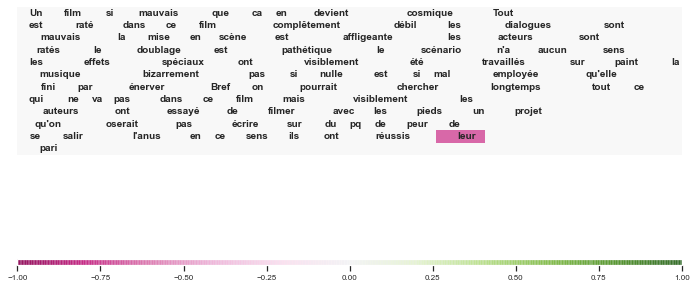



7086
True label : 0


Un pure chef d'oeuvre du 7ème art que le film avalon nous montre.Un film dont la musiques et l'action sont de bonnes qualitées et qu'il n'est à manquer sous aucun prétexte. EXCELLENT à voir un film avoir en dvd.


CNN Character level
Proba class 1 : 0.9971277117729187


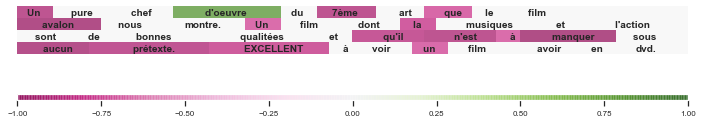

Embed CNN
Proba class 1 : 0.9902825355529785


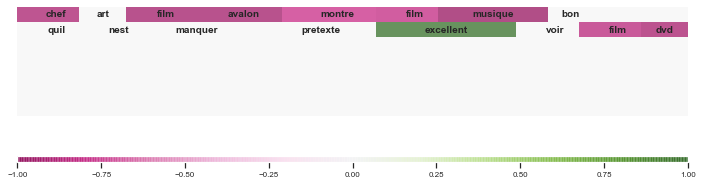

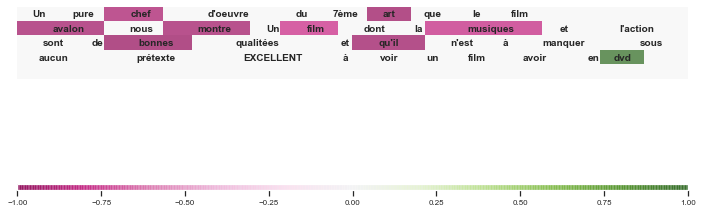

BILSTM CNN
Proba class 1 : 0.9982613921165466


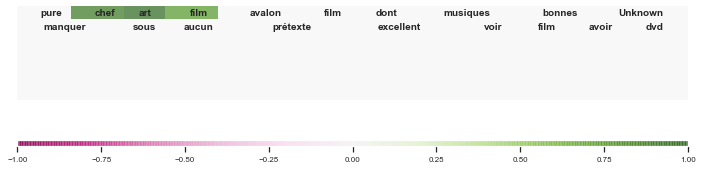

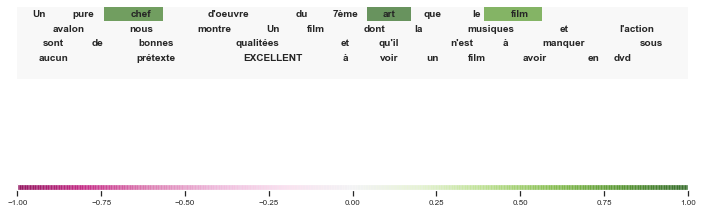



13266
True label : 1


Voilà un bon film, au propos très intéressant bien que parfois grossier. On y voit les "affaires" pas toujours claires de ceux qui nous gouvernent, leur connivence avec les médias, et dans certains cas leur pouvoir de censure. Un film assez pertinent mais pourtant très méconnu, sans doute qu'il dérange...


CNN Character level
Proba class 1 : 0.541659951210022


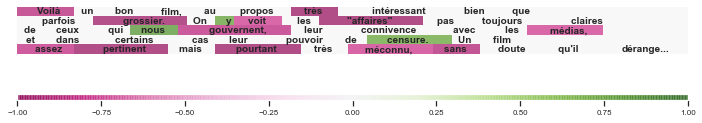

Embed CNN
Proba class 1 : 0.8200972080230713


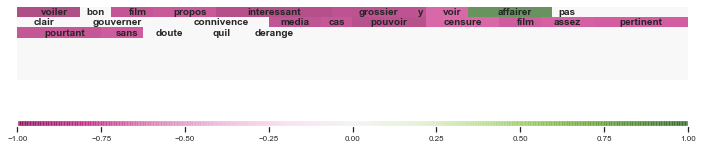

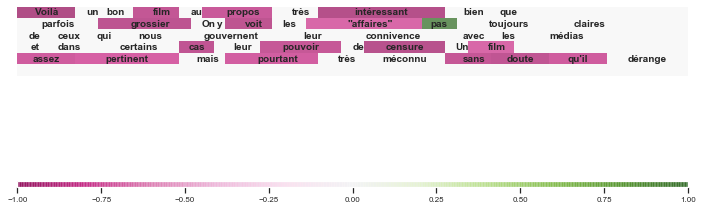

BILSTM CNN
Proba class 1 : 0.9948264956474304


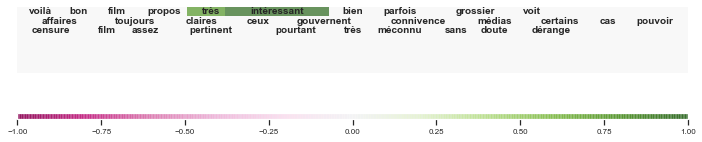

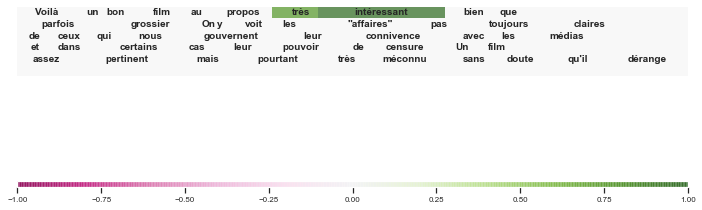



18237
True label : 1


une comédie horrifique très drole mais très mal fait le bonhomme de neige !!! il est en mousse en fait. sinon le film est bien gore, les acteurs ne sont pas vraiment mauvais, l'humour est bien semé... bref, une bonne rigolade ce film


CNN Character level
Proba class 1 : 0.4507620930671692


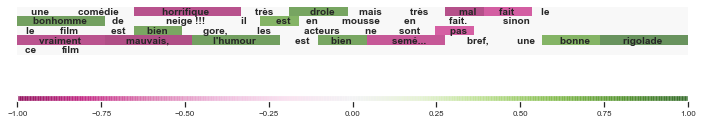

Embed CNN
Proba class 1 : 0.11598379164934158


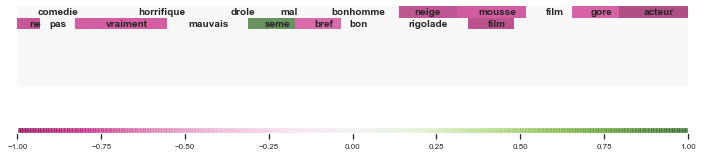

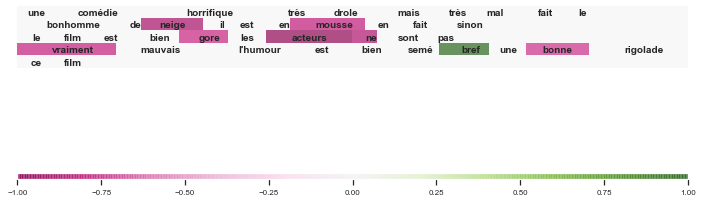

BILSTM CNN
Proba class 1 : 0.9142495393753052


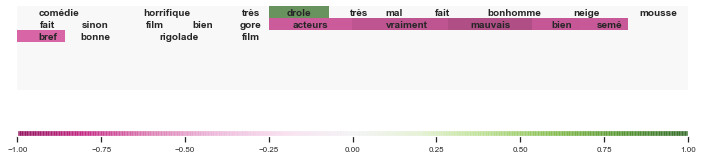

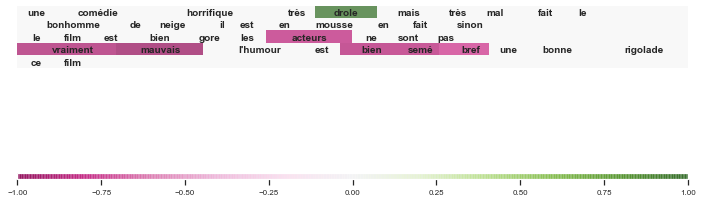

In [103]:
# with threshold
for i in range(index_to_print.shape[0]):
    index= index_to_print[i]
    print("\n")
    print(index)
    print("True label : {}".format(label_data[i]))
    print("\n")
    initial_review= initial_review_tt[index]
    print(initial_review)
    print("\n")
    print_all_model_interpretability(index, threshold= 0.75)